In [1]:
from datetime import datetime
from dateutil.parser import parse
import pandas as pd
import spacy, glob, os
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans2, whiten
from sklearn.cluster import KMeans
import spacy, re
from collections import Counter
from datetime import datetime
from dateutil.parser import parse
import pandas as pd
import spacy, glob, os
import numpy as np

from sklearn import feature_extraction

import re

import nltk
from nltk.tokenize import word_tokenize

# for wordnet (synonyms, antonyms, related words, etc)
nltk.download('wordnet')
from nltk.corpus import wordnet

# for finding root words
from nltk.stem.wordnet import WordNetLemmatizer

# for filtering out stop words
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

from gensim import corpora
import gensim
import pickle


[nltk_data] Downloading package wordnet to /home/michael/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/michael/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
nlp = spacy.load('en_core_web_sm', disable=['parser'])
nlp.remove_pipe('ner')
# nlp.remove_pipe('parser')

('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x7fd0fb1fd768>)

In [3]:
f = open('dataset.tsv', 'r')
# docs = pd.DataFrame(f.read())

df1 = pd.DataFrame.from_csv(f, sep='\t', index_col=None)

/home/michael/anaconda3/envs/anlp/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  after removing the cwd from sys.path.
/home/michael/anaconda3/envs/anlp/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [4]:
df1_us = df1[df1["country"]=="us"]
df1_us = df1_us.reset_index(drop=True)


In [5]:
def lemmatize(word):
    lemma = wordnet.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
def word_net_lemmatize(word):
    return WordNetLemmatizer().lemmatize(word)

def generate_lda_tokens(text):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [lemmatize(token) for token in tokens]
    tokens = [word_net_lemmatize(token) for token in tokens]

    return tokens

In [6]:
training_content_data = []

for index, row in df1_us.iterrows():
    training_content_data.append(generate_lda_tokens(row['comments']))

dictionary = corpora.Dictionary(training_content_data)
corpus = [dictionary.doc2bow(text) for text in training_content_data]

pickle.dump(corpus, open('lda/corpus.pkl', 'wb'))
dictionary.save('lda/dictionary.gensim')

In [ ]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, 
                                           num_topics = 150, 
                                           id2word=dictionary, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=100,
                                           alpha='auto',
                                           per_word_topics=False)
ldamodel.save('lda/model.gensim')
topics = ldamodel.print_topics(num_words=4)

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=ldamodel, texts=training_content_data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nLDA Coherence Score: ', coherence_lda)

In [5]:
# USED TO FIND BEST K, DO NOT RUN. TAKES AN HOUR

# Sum_of_squared_distances = []
# K = range(50, 500, 5)
# for k in K:
#     km = KMeans(n_clusters=k)
#     km = km.fit(coordinates)
#     Sum_of_squared_distances.append(km.inertia_)
    
# plt.plot(K, Sum_of_squared_distances, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Sum_of_squared_distances')
# plt.title('Elbow Method For Optimal k')
# plt.show()

# print(coordinates)


/Users/mugdhab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/Users/mugdhab/.local/lib/python3.7/site-packages/scipy/cluster/vq.py:580: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


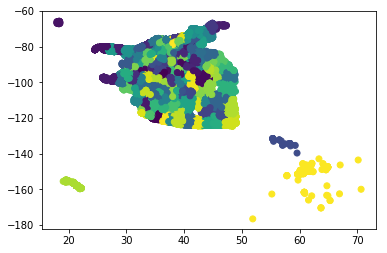

[ 29.8830556 -97.9411111] 55
[ 28.9783333 -96.6458333] 55
[  21.4180556 -157.8036111] 130
[ 36.595     -82.1888889] 95
[ 41.1175    -73.4083333] 82
[ 33.5861111 -86.2861111] 117
[ 30.2947222 -82.9841667] 76
[  33.9163889 -118.3516667] 107
[ 35.2333333 -82.7344444] 74
[ 40.6686111 -73.5275   ] 82
[ 37.1536111 -83.7619444] 95
[ 35.8238889 -80.2536111] 115
[ 36.8430556 -83.3219444] 95
[ 42.5377778 -83.2330556] 53
[ 41.3252778 -72.1936111] 73
[ 42.3916667 -71.5666667] 79
[ 38.1055556 -98.6597222] 22
[ 32.8544444 -79.975    ] 42
[  45.5827778 -122.3522222] 93
[ 29.4238889 -98.4933333] 55
[ 38.2541667 -85.7594444] 44
[ 40.7008333 -73.7133333] 82
[ 41.7002778 -73.9213889] 73
[  32.7152778 -117.1563889] 141
[  38.7583333 -104.7425   ] 90
[ 29.7630556 -95.3630556] 92
[ 32.7833333 -96.8      ] 63
[ 42.9955556 -71.4552778] 79
[ 29.7630556 -95.3630556] 92
[ 44.7630556 -85.6205556] 49
[ 41.0338889 -73.7633333] 82
[ 43.0388889 -87.9063889] 56
[ 43.9627778 -70.2830556] 25
[  40.015 -105.27 ] 39
[  47

[ 41.6027778 -87.7438889] 14
[ 41.6027778 -87.7438889] 14
[ 41.6316667 -87.6813889] 14
[ 38.5730556 -82.8302778] 44
[ 25.4683333 -80.4777778] 7
[  35.0844444 -106.6505556] 47
[ 26.6155556 -80.0572222] 7
[  33.4483333 -112.0733333] 10
[  34.0522222 -118.2427778] 107
[ 26.7052778 -80.0366667] 7
[ 45.1888889 -93.5527778] 133
[ 30.6647222 -97.9222222] 19
[  37.3394444 -121.8938889] 71
[  38.2972222 -122.2844444] 135
[ 39.4733333 -82.7394444] 17
[ 35.4675    -97.5161111] 132
[ 45.07      -85.2644444] 49
[ 41.5733333 -87.7844444] 14
[ 41.9025    -85.7994444] 14
[  35.2333333 -106.6638889] 47
[ 32.8138889 -96.9486111] 63
[  34.0094444 -118.1044444] 107
[ 40.7141667 -74.0063889] 82
[ 32.7938889 -79.8627778] 42
[ 41.6269444 -88.2038889] 14
[ 39.1886111 -91.9827778] 123
[ 43.07      -94.2327778] 4
[  48.7838889 -117.8105556] 131
[ 39.5786111 -76.6158333] 142
[  36.175     -115.1363889] 97
[ 30.2669444 -97.7427778] 92
[  47.5675 -121.8875] 138
[  45.6666667 -122.5597222] 93
[  46.7313889 -117.178

[  45.4611111 -123.9666667] 93
[ 34.5861111 -94.2394444] 15
[  42.5630556 -114.46     ] 139
[ 39.2666667 -81.5616667] 59
[ 32.7630556 -80.2502778] 42
[ 40.9113889 -73.7827778] 82
[ 34.2738889 -92.0908333] 15
[ 36.1880556 -94.5402778] 0
[ 26.9338889 -80.0944444] 7
[  43.6136111 -116.2025   ] 29
[  42.5630556 -114.46     ] 139
[ 36.1880556 -96.49     ] 0
[ 36.1880556 -96.49     ] 0
[  33.4222222 -111.8219444] 10
[ 25.7738889 -80.1938889] 7
[ 32.4797222 -86.3619444] 64
[  37.6819444 -121.7669444] 71
[ 44.4583333 -93.1613889] 133
[  37.6688889 -122.0797222] 71
[ 33.1136111 -94.1641667] 2
[ 26.2125 -80.25  ] 7
[ 44.7966667 -68.7619444] 25
[  34.7083333 -120.4666667] 1
[  45.9975    -121.5269444] 93
[  32.7677778 -117.0222222] 141
[ 39.9522222 -75.1641667] 142
[  41.7911111 -107.2380556] 122
[ 30.0858333 -94.1016667] 92
[ 41.2586111 -95.9375   ] 144
[ 38.9791667 -94.9683333] 8
[ 30.5402778 -88.6875   ] 41
[ 29.7855556 -95.8241667] 92
[  36.0397222 -114.9811111] 97
[ 38.8461111 -77.3066667] 1

[ 34.7694444 -92.2669444] 15
[  46.9755556 -123.8144444] 138
[ 35.9605556 -83.9208333] 95
[  35.7069444 -118.4552778] 1
[ 39.3994444 -84.5613889] 17
[  33.4222222 -111.8219444] 10
[ 43.1963889 -75.7308333] 85
[ 41.76      -70.0833333] 73
[ 40.3461111 -94.8722222] 103
[  37.9608333 -120.2363889] 71
[ 40.2986111 -83.0680556] 17
[ 29.6513889 -82.325    ] 76
[  34.8697222 -111.7602778] 98
[ 41.8358333 -96.4666667] 144
[  32.6788889 -115.4980556] 121
[ 29.9480556 -93.9169444] 92
[ 42.3316667 -71.1216667] 79
[ 26.9294444 -82.0455556] 81
[  34.4113889 -118.5391667] 107
[ 41.6469444 -73.5686111] 73
[  47.5002778 -111.3      ] 131
[  44.1752778 -122.1627778] 89
[ 40.2169444 -74.7433333] 75
[ 38.9716667 -95.235    ] 8
[ 33.8905556 -78.5686111] 18
[  33.5091667 -111.8983333] 10
[ 39.2902778 -76.6125   ] 116
[ 40.7391667 -89.0163889] 16
[ 34.9247222 -81.0252778] 74
[ 44.98      -93.2636111] 133
[ 44.9444444 -93.0930556] 133
[  33.4483333 -112.0733333] 10
[ 30.155     -95.2111111] 92
[ 43.8013889 -

[ 41.6005556 -93.6088889] 6
[  61.2180556 -149.9002778] 148
[ 41.7255556 -87.825    ] 14
[ 39.5236111 -87.125    ] 119
[ 41.6027778 -87.7438889] 14
[ 38.2541667 -85.7594444] 44
[ 38.2933333 -83.6588889] 44
[ 40.0063889 -75.7036111] 142
[ 28.5380556 -81.3794444] 13
[  35.0844444 -106.6505556] 47
[ 34.2255556 -77.945    ] 58
[ 35.1494444 -90.0488889] 37
[  34.9530556 -120.4347222] 1
[  33.5805556 -112.2366667] 10
[  34.2694444 -118.7805556] 107
[ 37.7272222 -89.2166667] 126
[ 42.7022222 -83.4027778] 53
[  34.0522222 -118.2427778] 107
[ 33.6888889 -78.8869444] 18
[ 33.6888889 -78.8869444] 18
[ 32.9344444 -97.2513889] 63
[ 33.66      -86.8127778] 117
[ 32.9263889 -96.8958333] 63
[ 31.0727778 -96.9783333] 19
[ 38.8113889 -90.8527778] 28
[ 41.12      -87.8611111] 80
[ 32.7833333 -96.8      ] 63
[ 39.7683333 -86.1580556] 119
[  32.2216667 -110.9258333] 70
[ 35.6008333 -82.5541667] 74
[ 38.4730556 -77.9969444] 149
[ 35.7719444 -78.6388889] 115
[ 43.0388889 -87.9063889] 56
[ 44.9444444 -93.0930

[ 29.4238889 -98.4933333] 55
[ 29.7630556 -95.3630556] 92
[ 38.4313889 -92.8408333] 101
[ 29.7855556 -95.8241667] 92
[ 44.1538889 -87.5691667] 118
[ 42.3708333 -71.1833333] 79
[ 34.1619444 -97.4255556] 140
[ 39.7530556 -74.2233333] 142
[ 39.7852778 -75.9791667] 142
[ 36.31      -96.4638889] 0
[ 38.3697222 -90.3783333] 28
[ 42.5311111 -88.2480556] 56
[ 40.4405556 -79.9961111] 9
[  33.6694444 -117.8222222] 107
[ 41.5355556 -73.8994444] 73
[  45.715     -121.4633333] 93
[  38.4405556 -122.7133333] 135
[ 44.6402778 -93.1433333] 133
[ 34.9158333 -85.1091667] 145
[  34.0522222 -118.2427778] 107
[  34.8697222 -111.7602778] 98
[  34.0686111 -118.0266667] 107
[ 41.5244444 -90.5155556] 16
[  34.0952778 -118.1261111] 107
[ 36.1538889 -95.9925   ] 0
[ 43.1725    -79.0361111] 85
[  44.4633333 -118.7088889] 29
[  37.7397222 -121.4241667] 71
[  44.6369444 -124.0522222] 89
[ 32.3525    -90.8777778] 83
[  48.1958333 -114.3119444] 131
[ 35.9488889 -85.0269444] 66
[  64.8377778 -147.7163889] 148
[ 29.423

[ 44.98      -93.2636111] 133
[  39.7391667 -104.9841667] 39
[ 40.7933333 -77.8602778] 9
[  38.1041667 -122.2555556] 71
[ 25.6047222 -80.3538889] 7
[  42.8713889 -112.4447222] 139
[ 33.5861111 -86.2861111] 117
[ 32.1533333 -90.1311111] 83
[  41.5511111 -112.1094444] 87
[ 32.7355556 -97.1077778] 63
[  33.6602778 -117.9983333] 107
[ 33.9561111 -83.9880556] 91
[ 36.1344444 -80.6597222] 115
[  35.1477778 -114.5675   ] 98
[ 40.3922222 -79.9002778] 9
[ 42.325     -72.6416667] 79
[  33.5805556 -112.2366667] 10
[  47.7361111 -122.6452778] 138
[  47.6063889 -122.3308333] 138
[  33.3794444 -108.9027778] 136
[ 29.7630556 -95.3630556] 92
[  42.225     -121.7805556] 143
[  33.4483333 -112.0733333] 10
[  33.4483333 -112.0733333] 10
[ 38.9716667 -95.235    ] 8
[ 37.585     -79.0516667] 108
[ 40.7919444 -74.0041667] 82
[  46.8397222 -119.0511111] 35
[ 39.8016667 -89.6436111] 3
[ 40.4538889 -75.8183333] 75
[  32.7152778 -117.1563889] 141
[  45.7544444 -122.8763889] 93
[  39.8366667 -105.0366667] 39
[ 3

[ 41.2938889 -82.2175   ] 45
[ 39.4886111 -83.6369444] 17
[ 39.9947222 -84.4080556] 17
[ 43.38   -71.7175] 67
[ 33.4416667 -94.0375   ] 2
[  37.775     -122.4183333] 71
[ 36.0647222 -86.9394444] 66
[  33.5386111 -112.1852778] 10
[ 39.6283333 -84.1594444] 17
[ 39.0769444 -84.1769444] 17
[ 39.3236111 -83.6911111] 17
[ 39.3994444 -84.5613889] 17
[ 39.3236111 -83.6911111] 17
[ 29.9425    -89.9633333] 41
[ 34.5036111 -93.055    ] 15
[ 30.2669444 -97.7427778] 92
[ 43.0255556 -74.9863889] 85
[ 34.8088889 -79.5480556] 58
[ 38.8941667 -77.4313889] 116
[ 37.6455556 -84.7722222] 44
[ 41.1844444 -73.1336111] 82
[ 33.4016667 -86.9544444] 117
[ 36.2125    -79.7138889] 115
[  47.8108333 -122.3761111] 138
[ 29.7855556 -95.8241667] 92
[ 32.3525    -90.8777778] 83
[ 32.3525    -90.8777778] 83
[ 39.0997222 -94.5783333] 8
[  47.8108333 -122.3761111] 138
[ 35.245     -81.3413889] 74
[ 35.4661111 -82.5166667] 74
[ 42.2711111 -89.0938889] 14
[  46.9422222 -122.6047222] 138
[ 35.7963889 -81.4308333] 74
[ 46.7

[ 38.9716667 -95.235    ] 8
[  47.1719444 -122.5172222] 138
[ 35.0669444 -77.3530556] 58
[ 36.2080556 -86.2911111] 66
[  37.9061111 -122.5438889] 71
[  47.4741667 -122.2597222] 138
[ 30.2669444 -97.7427778] 92
[ 37.2708333 -79.9416667] 108
[  35.1894444 -114.0522222] 98
[ 40.7141667 -74.0063889] 82
[ 39.0283333 -84.2177778] 17
[ 33.7319444 -84.9191667] 91
[ 41.3405556 -87.6213889] 14
[ 40.4841667 -88.9936111] 3
[ 42.5005556 -90.6644444] 72
[  47.7988889 -122.4969444] 138
[ 40.1416667 -93.8722222] 103
[ 40.7141667 -74.0063889] 82
[  47.6063889 -122.3308333] 138
[ 42.5005556 -90.6644444] 72
[  34.0583333 -106.8908333] 136
[  46.4083333 -105.84     ] 96
[  33.8702778 -117.9244444] 107
[  36.7477778 -119.7713889] 147
[ 27.7519444 -98.0694444] 11
[ 29.9116667 -95.0619444] 92
[ 42.3683333 -83.3527778] 53
[ 38.3030556 -77.4608333] 149
[  33.6680556 -117.3263889] 107
[ 43.0797222 -98.2927778] 4
[  37.775     -122.4183333] 71
[  46.8722222 -113.9930556] 131
[ 44.0747222 -89.2877778] 118
[  45.6

[ 40.0063889 -75.7036111] 142
[ 41.8005556 -73.1216667] 73
[ 45.1       -87.6305556] 118
[  40.8486111 -111.9061111] 87
[  36.3302778 -119.2911111] 147
[ 42.7883333 -71.2013889] 79
[ 34.0005556 -81.035    ] 18
[ 41.9141667 -88.3086111] 14
[ 42.6555556 -70.6208333] 79
[ 40.4405556 -79.9961111] 9
[ 38.6272222 -90.1977778] 28
[  48.6969444 -122.9041667] 138
[ 36.1630556 -82.8311111] 95
[ 40.8       -96.6666667] 144
[  33.8358333 -118.3397222] 107
[  34.0522222 -118.2427778] 107
[  44.9111111 -116.0977778] 29
[ 41.8730556 -72.1219444] 73
[ 29.7855556 -95.8241667] 92
[  40.1672222 -105.1013889] 33
[  47.885     -120.1572222] 138
[ 27.2927778 -81.3630556] 81
[  40.485     -106.8311111] 33
[  47.5675    -122.6313889] 138
[  42.9275 -123.28  ] 143
[ 28.5997222 -81.3394444] 13
[ 32.6452778 -85.3783333] 64
[  34.2011111 -118.5355556] 107
[ 26.5863889 -80.0522222] 7
[  46.6022222 -120.5047222] 35
[ 41.3080556 -72.9286111] 73
[ 40.9688889 -73.7130556] 82
[ 30.3319444 -81.6558333] 76
[ 44.2722222 -

[  33.6638889 -114.2291667] 10
[ 30.1102778 -97.315    ] 92
[ 47.93      -97.0241667] 57
[ 42.9572222 -83.8305556] 53
[ 32.7502778 -81.6369444] 42
[  39.8680556 -104.9713889] 39
[  33.0580556 -112.0469444] 10
[ 44.1002778 -70.2152778] 25
[ 33.7488889 -84.3880556] 91
[ 42.4683333 -82.9555556] 53
[ 34.7302778 -86.5861111] 145
[ 39.9536111 -74.1983333] 142
[ 32.2094444 -99.7963889] 63
[ 35.8230556 -79.8611111] 115
[  33.8675    -117.9972222] 107
[ 26.1219444 -80.1436111] 7
[  64.7511111 -147.3494444] 148
[  38.2547222 -121.2988889] 135
[ 37.2708333 -79.9416667] 108
[  34.1477778 -118.1436111] 107
[ 29.875     -98.2622222] 55
[ 38.7891667 -77.1875   ] 116
[ 34.7369444 -82.2544444] 74
[ 30.3319444 -81.6558333] 76
[ 30.3319444 -81.6558333] 76
[ 27.1972222 -80.2530556] 81
[  32.7152778 -117.1563889] 141
[ 27.8161111 -80.4708333] 81
[  48.3888889 -122.495    ] 138
[ 26.8230556 -80.1388889] 7
[ 41.8458333 -70.95     ] 73
[ 42.5388889 -71.0486111] 79
[  36.175     -115.1363889] 97
[ 40.975     -

[  33.7738889 -117.9405556] 107
[  37.775     -122.4183333] 71
[ 41.5569444 -83.6272222] 45
[ 41.0813889 -81.5191667] 45
[  39.7391667 -104.9841667] 39
[ 42.4286111 -87.9238889] 14
[ 40.0063889 -75.7036111] 142
[ 26.4611111 -80.0730556] 7
[ 29.6908333 -95.2088889] 92
[ 29.8680556 -94.8325   ] 92
[ 33.6888889 -78.8869444] 18
[ 39.0305556 -82.8244444] 59
[ 44.2563889 -70.2566667] 25
[ 38.5922222 -89.9111111] 28
[ 43.2983333 -72.4827778] 67
[ 40.9311111 -73.8991667] 82
[ 40.6319444 -73.7130556] 82
[ 32.2730556 -89.9858333] 83
[ 30.4866667 -90.9561111] 41
[ 35.3847222 -77.9930556] 115
[ 32.2744444 -90.1319444] 83
[ 44.8755556 -91.9191667] 133
[ 32.3525    -90.8777778] 83
[ 42.0372222 -88.2811111] 14
[ 41.4277778 -74.1663889] 82
[ 42.5802778 -83.0302778] 53
[ 30.4313889 -98.3444444] 92
[ 40.8475    -77.6863889] 9
[  37.3022222 -120.4819444] 147
[ 41.2427778 -73.2011111] 82
[ 38.7744444 -75.1397222] 24
[ 41.7647222 -98.0802778] 144
[ 29.4238889 -98.4933333] 55
[  39.5347222 -107.7825   ] 39


[  33.6116667 -111.7166667] 10
[  47.6063889 -122.3308333] 138
[ 43.9705556 -89.8166667] 118
[  39.0638889 -108.55     ] 90
[ 36.8188889 -76.2752778] 60
[ 40.835     -73.1316667] 82
[  33.6       -117.6711111] 107
[ 36.8188889 -76.2752778] 60
[  46.1383333 -122.9369444] 93
[ 40.1413889 -74.1002778] 75
[ 26.5625    -81.9497222] 7
[  45.6388889 -122.6602778] 93
[  45.6388889 -122.6602778] 93
[  45.0244444 -123.9452778] 93
[ 41.9       -71.0902778] 73
[  45.6388889 -122.6602778] 93
[ 40.7258333 -73.5147222] 82
[ 41.8455556 -87.7538889] 14
[ 44.1511111 -72.4933333] 67
[  48.7597222 -122.4869444] 138
[  40.2969444 -111.6938889] 87
[  38.5816667 -121.4933333] 135
[  37.5958333 -122.0180556] 71
[  37.5958333 -122.0180556] 71
[  47.7661111 -116.7855556] 131
[  61.2180556 -149.9002778] 148
[  40.7608333 -111.8902778] 87
[  40.5  -111.95] 87
[  40.5308333 -112.2975   ] 87
[ 34.5441667 -91.9688889] 15
[ 35.9605556 -83.9208333] 95
[  37.8716667 -122.2716667] 71
[  47.2530556 -122.4430556] 138
[ 37

[  37.5630556 -122.3244444] 71
[ 41.2622222 -73.615    ] 82
[ 35.3627778 -84.2941667] 145
[  47.2530556 -122.4430556] 138
[ 33.3047222 -83.6833333] 111
[  34.1477778 -118.1436111] 107
[ 35.2030556 -85.9211111] 145
[ 32.4486111 -81.7833333] 42
[  47.3075    -122.2272222] 138
[  36.0397222 -114.9811111] 97
[ 35.9605556 -83.9208333] 95
[ 43.7438889 -85.2972222] 49
[ 40.8       -96.6666667] 144
[  33.7763889 -112.5277778] 10
[  36.5963889 -119.4494444] 147
[ 25.7738889 -80.1938889] 7
[  37.775     -122.4183333] 71
[ 25.7738889 -80.1938889] 7
[  34.1808333 -118.3080556] 107
[ 32.0833333 -81.1      ] 42
[  36.6777778 -121.6544444] 147
[  33.94      -118.1316667] 107
[  38.35      -104.7222222] 125
[  33.7877778 -117.8522222] 107
[ 41.6413889 -80.1516667] 45
[ 31.7380556 -99.9469444] 19
[  31.8575    -103.0922222] 84
[ 35.2269444 -80.8433333] 74
[  34.2783333 -119.2922222] 107
[  33.0580556 -112.0469444] 10
[  41.465     -112.0316667] 87
[ 39.0508333 -74.7583333] 24
[  38.0280556 -121.8836111

[ 39.1580556 -75.5247222] 24
[  38.5472222 -122.8152778] 135
[  38.5472222 -122.8152778] 135
[  38.5472222 -122.8152778] 135
[  34.0775    -117.6888889] 107
[  38.5472222 -122.8152778] 135
[ 42.5277778 -92.4452778] 72
[ 26.5625    -81.9497222] 7
[ 41.955 -87.94 ] 14
[ 40.0322222 -74.9577778] 142
[ 40.2430556 -79.2377778] 9
[ 25.7738889 -80.1938889] 7
[ 40.7141667 -74.0063889] 82
[  34.1477778 -118.1436111] 107
[ 38.935     -74.9063889] 24
[ 40.6788889 -73.4175   ] 82
[  32.7152778 -117.1563889] 141
[ 41.575     -87.2388889] 14
[ 27.7705556 -82.6794444] 81
[ 25.9083333 -80.3088889] 7
[  28.7088889 -100.4991667] 55
[ 41.85 -87.65] 14
[ 33.2669444 -93.2391667] 2
[  44.9430556 -123.0338889] 93
[ 41.6252778 -87.7175   ] 14
[ 38.4213889 -78.1938889] 149
[  34.4838889 -114.3216667] 98
[ 33.5205556 -86.8025   ] 117
[  34.1808333 -118.3080556] 107
[  34.1808333 -118.3080556] 107
[  32.7947222 -116.9616667] 141
[  36.175     -115.1363889] 97
[  37.5483333 -121.9875   ] 71
[  38.005     -121.8047

[  34.1808333 -118.3080556] 107
[ 42.3716667 -88.09     ] 14
[ 46.33      -94.4738889] 128
[  37.9480556 -122.0597222] 71
[ 45.2788889 -92.985    ] 133
[ 30.3958333 -88.8852778] 41
[  38.5733333 -109.5491667] 90
[ 32.7833333 -96.8      ] 63
[ 36.1511111 -95.5091667] 0
[  35.6869444 -105.9372222] 94
[ 42.5555556 -72.0680556] 79
[  36.175     -115.1363889] 97
[ 38.9716667 -95.235    ] 8
[  40.8022222 -124.1625   ] 50
[ 41.9911111 -70.8625   ] 73
[ 44.56      -90.5961111] 118
[  31.7586111 -106.4863889] 84
[ 43.6852778 -85.8158333] 49
[ 41.2097222 -93.8463889] 6
[ 41.2097222 -93.8463889] 6
[  39.0058333 -122.0083333] 135
[ 29.4238889 -98.4933333] 55
[ 41.85 -87.65] 14
[ 41.85 -87.65] 14
[ 34.1013889 -84.5194444] 91
[  33.7738889 -117.9405556] 107
[ 41.1111111 -75.3866667] 82
[ 44.6688889 -90.1716667] 118
[ 36.8527778 -75.9783333] 60
[ 32.7355556 -97.1077778] 63
[ 41.865 -80.79 ] 45
[ 47.7444444 -93.6538889] 99
[ 38.2511111 -87.5811111] 126
[ 38.9908333 -88.1625   ] 28
[  34.6980556 -118.1

[  33.7669444 -118.1883333] 107
[  33.6469444 -117.6883333] 107
[  37.8716667 -122.2716667] 71
[  36.1544444 -109.5519444] 65
[ 36.4197222 -82.4766667] 95
[  38.5816667 -121.4933333] 135
[ 34.9202778 -82.2963889] 74
[  34.0852778 -117.96     ] 107
[  33.8536111 -118.1330556] 107
[ 37.3041667 -77.2875   ] 60
[  32.7152778 -117.1563889] 141
[ 30.4752778 -90.1008333] 41
[  34.2783333 -119.2922222] 107
[ 37.4097222 -79.9127778] 108
[  37.775     -122.4183333] 71
[  37.775     -122.4183333] 71
[ 27.8002778 -97.3961111] 11
[ 36.1630556 -82.8311111] 95
[  41.5266667 -124.0372222] 50
[ 38.2541667 -85.7594444] 44
[  45.3841667 -122.7627778] 93
[ 39.2688889 -84.2638889] 17
[ 35.9936111 -82.2591667] 95
[ 40.1497222 -75.4022222] 75
[ 39.0169444 -94.2813889] 8
[  32.64      -117.0833333] 141
[ 27.725     -82.7413889] 81
[ 41.5580556 -73.0519444] 73
[ 36.1961111 -86.6225   ] 66
[ 44.9483333 -93.3477778] 133
[  33.7669444 -118.1883333] 107
[ 29.6513889 -82.325    ] 76
[  36.1988889 -115.1166667] 97
[

[ 39.1580556 -75.5247222] 24
[ 39.1580556 -75.5247222] 24
[  33.6125    -117.7119444] 107
[ 38.2541667 -85.7594444] 44
[  40.5983333 -124.1561111] 50
[ 36.8366667 -93.2516667] 5
[  39.6536111 -105.1905556] 39
[ 41.85 -87.65] 14
[  33.2480556 -100.5733333] 52
[  39.5297222 -119.8127778] 134
[  36.175     -115.1363889] 97
[  34.0522222 -118.2427778] 107
[  47.6063889 -122.3308333] 138
[ 38.9516667 -92.3338889] 123
[  37.3488889 -108.5852778] 65
[  44.0463889 -123.0208333] 89
[  39.7294444 -104.8313889] 39
[ 39.2883333 -77.2041667] 116
[ 41.85 -87.65] 14
[ 41.0813889 -81.5191667] 45
[  45.4944444 -122.8658333] 93
[ 42.1686111 -88.2575   ] 14
[  39.7391667 -104.9841667] 39
[  37.6819444 -121.7669444] 71
[ 34.2563889 -99.5163889] 46
[ 39.9611111 -82.9988889] 17
[  34.1083333 -117.2888889] 107
[ 40.7555556 -73.8858333] 82
[ 37.8144444 -82.8072222] 108
[ 33.7480556 -86.8086111] 117
[  47.9791667 -122.2008333] 138
[ 33.6741667 -94.1311111] 140
[ 30.6941667 -88.0430556] 41
[ 34.1741667 -86.6163

[ 43.5325 -90.0025] 56
[  38.2972222 -122.2844444] 135
[ 27.5872222 -82.4252778] 81
[  48.0841667 -121.9675   ] 138
[ 32.3663889 -96.1005556] 63
[ 39.7686111 -94.8463889] 103
[  38.6447222 -121.2711111] 135
[ 36.3916667 -75.98     ] 60
[ 28.8827778 -81.3088889] 13
[ 38.3294444 -89.1908333] 28
[ 38.6272222 -90.1977778] 28
[ 39.9522222 -75.1641667] 142
[ 42.0111111 -87.8405556] 14
[ 41.8994444 -87.9402778] 14
[ 45.4358333 -89.1833333] 109
[  39.5538889 -104.9688889] 39
[  33.7455556 -117.8669444] 107
[  21.4022222 -157.7394444] 130
[  47.6063889 -122.3308333] 138
[  37.7022222 -121.9347222] 71
[ 42.0963889 -83.2919444] 53
[ 38.7302778 -82.8555556] 59
[  34.2541667 -110.0291667] 98
[  34.1141667 -116.4313889] 107
[  34.8986111 -117.0219444] 1
[ 32.7458333 -96.9975   ] 63
[ 37.6144444 -93.4102778] 101
[ 35.2783333 -93.1336111] 31
[  36.1988889 -115.1166667] 97
[  33.4483333 -112.0733333] 10
[ 42.5791667 -84.4436111] 53
[ 33.1136111 -94.1641667] 2
[ 36.2944444 -76.2513889] 60
[ 31.1497222 -

[ 30.3672222 -89.0927778] 41
[  32.7152778 -117.1563889] 141
[  35.0844444 -106.6505556] 47
[ 28.4772222 -81.9061111] 13
[ 47.9033333 -91.8669444] 99
[ 47.6472222 -90.6747222] 99
[ 39.1752778 -84.2944444] 17
[  38.0672222 -117.2291667] 105
[  40.5866667 -122.3905556] 50
[ 27.5061111 -99.5072222] 11
[  40.015 -105.27 ] 39
[ 42.8125    -86.0186111] 53
[  42.8666667 -106.3125   ] 122
[ 26.4611111 -80.0730556] 7
[  36.6061111 -118.0619444] 147
[ 41.0127778 -81.6052778] 45
[ 44.4686111 -71.1855556] 25
[ 28.5380556 -81.3794444] 13
[  47.4958333 -121.7855556] 138
[ 34.2255556 -77.945    ] 58
[ 42.9119444 -83.9847222] 53
[ 26.5625    -81.9497222] 7
[ 32.7938889 -79.8627778] 42
[  37.0808333 -119.4844444] 147
[  32.2216667 -110.9258333] 70
[  41.1238889 -100.765    ] 146
[ 44.8833333 -93.2827778] 133
[ 41.2586111 -95.9375   ] 144
[ 39.8494444 -75.3561111] 142
[ 43.5944444 -83.8888889] 49
[  40.015 -105.27 ] 39
[ 29.7630556 -95.3630556] 92
[  42.8666667 -106.3125   ] 122
[  45.7202778 -123.89277

[ 33.8941667 -83.9558333] 91
[  19.9430556 -155.7902778] 130
[ 39.9080556 -85.9227778] 119
[ 36.3955556 -80.7227778] 95
[  33.4222222 -111.8219444] 10
[ 28.8355556 -82.3305556] 13
[ 41.8975    -71.9630556] 73
[ 28.8355556 -82.3305556] 13
[ 38.5725    -90.8819444] 28
[ 38.9822222 -94.6705556] 8
[ 40.63      -79.9697222] 9
[ 41.2794444 -72.8155556] 73
[  64.8377778 -147.7163889] 148
[ 41.2052778 -96.0422222] 144
[ 39.0702778 -76.5455556] 116
[ 39.3111111 -94.9222222] 8
[  40.3141667 -112.0061111] 87
[ 35.2922222 -81.5358333] 74
[  45.6388889 -122.6602778] 93
[ 42.4733333 -83.2219444] 53
[ 29.2672222 -97.7641667] 55
[  34.5636111 -111.8536111] 98
[ 26.0519444 -80.1441667] 7
[  21.3069444 -157.8583333] 130
[  37.6625    -121.8736111] 71
[ 29.9033333 -90.0772222] 41
[ 26.6583333 -80.2416667] 7
[  39.6402778 -106.3736111] 39
[  33.1580556 -117.3497222] 141
[  34.61  -112.315] 98
[ 40.26      -74.2741667] 75
[  32.3122222 -106.7777778] 84
[  34.54      -112.4677778] 98
[ 39.7391667 -75.598333

[ 42.5222222 -83.3061111] 53
[  47.5002778 -111.3      ] 131
[  33.8188889 -108.9538889] 10
[  47.8211111 -122.3138889] 138
[  34.1705556 -118.8366667] 107
[  46.5377778 -111.9319444] 48
[ 40.2113889 -74.7883333] 75
[  40.6461111 -111.4972222] 87
[ 37.7561111 -94.3058333] 101
[ 34.5325 -83.985 ] 91
[  37.485     -119.9652778] 71
[  37.9975    -121.7113889] 71
[  34.1625 -112.85  ] 98
[  38.3566667 -121.9866667] 135
[ 40.8688889 -72.5180556] 82
[  36.5433333 -114.4461111] 97
[ 39.4575    -77.7491667] 116
[  37.4636111 -122.4275   ] 71
[ 34.9494444 -81.9322222] 74
[  47.6816667 -122.2075   ] 138
[ 36.2613889 -90.9711111] 30
[ 38.1986111 -92.6386111] 101
[ 36.0725    -79.7922222] 115
[ 42.8941667 -74.345    ] 79
[  34.0975 -117.6475] 107
[ 30.275     -98.8716667] 55
[ 33.1136111 -94.1641667] 2
[ 38.5291667 -76.9755556] 149
[  46.3238889 -120.0075   ] 35
[ 28.5380556 -81.3794444] 13
[  40.1672222 -105.1013889] 33
[  37.3230556 -122.0311111] 71
[ 35.7719444 -78.6388889] 115
[ 43.0880556 -70

[ 41.1008333 -74.1166667] 82
[  44.0522222 -123.0855556] 89
[  34.0702778 -117.395    ] 107
[ 37.3041667 -77.2875   ] 60
[ 31.1275    -84.1519444] 64
[ 42.525     -71.7602778] 79
[ 43.7333333 -88.5686111] 56
[ 45.0847222 -93.0097222] 133
[ 41.4225    -87.9858333] 14
[  47.6063889 -122.3308333] 138
[ 41.7758333 -72.5219444] 73
[  36.7477778 -119.7713889] 147
[  34.4838889 -114.3216667] 98
[  47.6105556 -122.1994444] 138
[  21.5902778 -158.1125   ] 130
[  46.3525    -124.0530556] 93
[ 33.9938889 -96.3705556] 140
[ 27.0994444 -82.4544444] 81
[  35.3733333 -119.0177778] 1
[ 43.6613889 -70.2558333] 67
[ 44.6994444 -73.4533333] 67
[ 28.5688889 -81.5441667] 13
[ 28.5997222 -81.3394444] 13
[ 41.3116667 -81.5683333] 45
[ 35.0525    -78.8786111] 58
[ 28.5688889 -81.5441667] 13
[ 35.1494444 -90.0488889] 37
[ 31.1277778 -92.0661111] 120
[ 38.5563889 -75.5716667] 24
[ 35.8233333 -78.8258333] 115
[  48.22  -122.685] 138
[  19.7297222 -155.09     ] 130
[ 43.185     -90.4430556] 56
[ 36.1894444 -82.95

[ 27.9472222 -82.4586111] 81
[  48.5127778 -122.6113889] 138
[  44.0583333 -121.3141667] 89
[  41.0594444 -124.1419444] 50
[  48.7597222 -122.4869444] 138
[ 28.1758333 -80.5902778] 13
[ 36.1538889 -95.9925   ] 0
[ 29.5375    -95.1180556] 92
[  48.4213889 -122.3327778] 138
[ 28.0183333 -82.1130556] 81
[ 44.9238889 -92.9591667] 133
[ 32.9975 -87.63  ] 117
[ 32.5797222 -84.5508333] 64
[  34.0522222 -118.2427778] 107
[ 30.2091667 -95.7505556] 92
[  34.0522222 -118.2427778] 107
[ 43.0388889 -87.9063889] 56
[ 32.5419444 -97.3205556] 63
[  37.6775    -113.0611111] 105
[ 29.6194444 -95.6347222] 92
[  33.4483333 -112.0733333] 10
[ 35.0525    -78.8786111] 58
[  46.2752778 -122.9063889] 93
[  35.0844444 -106.6505556] 47
[  35.0844444 -106.6505556] 47
[  45.6797222 -111.0377778] 48
[  45.6797222 -111.0377778] 48
[  44.0522222 -123.0855556] 89
[  44.0522222 -123.0855556] 89
[  45.5236111 -122.675    ] 93
[ 42.8263889 -84.2194444] 53
[  20.785     -156.4655556] 130
[  44.9430556 -123.0338889] 93
[ 2

[ 41.1688889 -82.2180556] 45
[  33.6680556 -117.3263889] 107
[ 28.9669444 -98.4783333] 55
[ 41.7002778 -73.9213889] 73
[ 38.7430556 -94.8252778] 8
[ 25.7738889 -80.1938889] 7
[  32.2216667 -110.9258333] 70
[ 42.3086111 -83.4822222] 53
[ 42.8863889 -78.8786111] 85
[  38.6786111 -121.7722222] 135
[ 39.5144444 -76.4113889] 142
[ 33.7488889 -84.3880556] 91
[ 41.6302778 -87.8538889] 14
[ 41.0263889 -73.6288889] 82
[ 41.5563889 -95.8875   ] 144
[ 37.9283333 -79.3194444] 149
[ 38.4277778 -82.4572222] 44
[ 38.6272222 -90.1977778] 28
[ 43.2813889 -83.5297222] 53
[ 40.6975    -74.2636111] 82
[  34.0522222 -118.2427778] 107
[  32.3908333 -110.9658333] 70
[ 42.1083333 -91.285    ] 72
[  33.4483333 -112.0733333] 10
[  61.2180556 -149.9002778] 148
[  39.6552778 -106.8280556] 39
[ 35.4602778 -94.7872222] 31
[ 41.3080556 -72.9286111] 73
[ 39.7683333 -86.1580556] 119
[ 41.4825 -73.41  ] 73
[ 40.1497222 -77.1286111] 142
[ 40.9133333 -77.7786111] 9
[ 39.8908333 -75.0733333] 142
[  35.265     -116.0736111

[ 39.2902778 -76.6125   ] 116
[  36.6844444 -121.8011111] 147
[ 27.3361111 -82.5308333] 81
[  37.3394444 -121.8938889] 71
[  39.0638889 -108.55     ] 90
[  47.7544444 -122.1622222] 138
[  42.0527778 -124.2827778] 143
[  32.7152778 -117.1563889] 141
[ 42.6525    -73.7566667] 79
[  32.7152778 -117.1563889] 141
[  32.7152778 -117.1563889] 141
[ 42.1861111 -86.3083333] 14
[  41.5102778 -112.0147222] 87
[ 36.9038889 -76.9      ] 60
[ 33.9472222 -90.3441667] 15
[ 41.8011111 -88.0747222] 14
[ 40.3891667 -74.7622222] 75
[ 39.0997222 -94.5783333] 8
[ 34.9494444 -81.9322222] 74
[ 38.0291667 -78.4769444] 149
[  21.4180556 -157.8036111] 130
[ 29.7630556 -95.3630556] 92
[ 38.6580556 -77.25     ] 116
[ 29.1869444 -82.1402778] 13
[  46.2730556 -123.9441667] 93
[ 36.5963889 -82.1886111] 95
[  47.3294444 -122.5788889] 138
[  40.2969444 -111.6938889] 87
[  34.0922222 -117.4341667] 107
[  48.0152778 -122.0625   ] 138
[  32.2216667 -110.9258333] 70
[ 42.575     -71.9986111] 79
[ 30.3672222 -89.0927778] 41

[ 43.1636111 -73.0727778] 79
[ 41.0997222 -80.6497222] 45
[ 29.7233333 -98.9355556] 55
[ 46.7638889 -89.0861111] 109
[ 36.5858333 -79.3952778] 115
[ 40.1794444 -74.8555556] 75
[ 40.7966667 -74.4819444] 82
[ 29.9688889 -95.6969444] 92
[ 35.4447222 -78.4272222] 115
[  33.9616667 -118.3522222] 107
[ 27.9472222 -82.4586111] 81
[ 40.4405556 -79.9961111] 9
[ 35.0302778 -91.9502778] 15
[  33.5805556 -112.2366667] 10
[ 40.4975    -74.4888889] 75
[  33.5805556 -112.2366667] 10
[ 43.6377778 -70.5194444] 67
[ 41.7758333 -72.5219444] 73
[ 45.1805556 -89.6833333] 118
[  33.8358333 -118.3397222] 107
[  39.8027778 -105.0869444] 39
[ 37.8172222 -96.8619444] 22
[ 29.7630556 -95.3630556] 92
[  34.6980556 -118.1358333] 1
[  36.9752778 -121.9522222] 147
[ 38.8047222 -77.0472222] 116
[ 32.7833333 -96.8      ] 63
[ 35.6125    -77.3666667] 115
[ 38.1494444 -79.0719444] 149
[  61.2180556 -149.9002778] 148
[ 39.6836111 -75.75     ] 142
[ 32.5344444 -92.7883333] 2
[  35.0844444 -106.6505556] 47
[ 40.5347222 -95

[  33.7738889 -117.9405556] 107
[  46.1469444 -122.9072222] 93
[ 41.4088889 -75.6627778] 40
[ 42.4133333 -89.0091667] 14
[  39.1405556 -121.6158333] 134
[ 35.5463889 -77.0525   ] 115
[ 26.9338889 -80.0944444] 7
[  38.2972222 -122.2844444] 135
[ 40.4147222 -74.3658333] 75
[ 35.0525    -78.8786111] 58
[  33.7669444 -118.1883333] 107
[ 40.7141667 -74.0063889] 82
[ 35.4427778 -84.5930556] 145
[  37.7652778 -122.2405556] 71
[ 26.9616667 -82.3527778] 81
[ 27.3361111 -82.5308333] 81
[ 39.3330556 -82.9825   ] 17
[  46.1383333 -122.9369444] 93
[ 36.2613889 -94.3575   ] 0
[  40.6111111 -111.8991667] 87
[  32.2216667 -110.9258333] 70
[  34.1361111 -117.8644444] 107
[  35.0844444 -106.6505556] 47
[ 34.4872222 -78.6563889] 58
[ 42.9813889 -70.9483333] 79
[  44.9111111 -116.0977778] 29
[  34.1808333 -118.3080556] 107
[ 38.8533333 -91.3058333] 123
[  47.4158333 -120.2919444] 138
[  47.4236111 -120.3091667] 138
[ 32.1108333 -98.5355556] 63
[ 35.0838889 -92.2077778] 15
[  47.0016667 -114.4725   ] 131
[

[ 41.24      -81.4408333] 45
[ 34.6080556 -82.1136111] 74
[ 34.8525    -82.3941667] 74
[ 18.0130556 -66.6144444] 7
[ 29.7630556 -95.3630556] 92
[  39.7969444 -105.4933333] 39
[ 31.3111111 -92.445    ] 120
[ 42.5791667 -84.4436111] 53
[ 42.5091667 -84.6558333] 53
[ 33.6488889 -85.5875   ] 117
[ 27.13      -80.8938889] 81
[ 18.4744444 -66.7161111] 7
[ 40.8013889 -72.8680556] 82
[  43.025     -108.3794444] 122
[ 30.2263889 -93.2172222] 92
[ 28.4055556 -80.605    ] 13
[  33.1191667 -117.0855556] 141
[  34.1066667 -117.8058333] 107
[  38.4405556 -122.7133333] 135
[ 37.2708333 -79.9416667] 108
[  42.7241667 -114.5177778] 139
[ 35.5463889 -77.0525   ] 115
[  36.6002778 -121.8936111] 147
[ 39.1619444 -84.4569444] 17
[ 29.7630556 -95.3630556] 92
[ 35.4675    -97.5161111] 132
[ 31.2180556 -96.7822222] 19
[ 32.8341667 -97.2286111] 63
[ 29.5777778 -98.6894444] 55
[ 33.1505556 -96.8233333] 63
[ 32.8138889 -96.9486111] 63
[ 27.8425    -82.6997222] 81
[ 39.2494444 -77.9588889] 116
[ 28.9002778 -81.26

[ 39.6416667 -77.7202778] 116
[ 39.7155556 -82.9530556] 17
[ 25.9561111 -80.1394444] 7
[  37.3861111 -122.0827778] 71
[ 41.4813889 -73.2136111] 73
[  34.4838889 -114.3216667] 98
[ 27.5872222 -82.4252778] 81
[ 43.55 -96.7 ] 4
[  20.785     -156.4655556] 130
[ 42.1013889 -72.5902778] 73
[  34.8697222 -111.7602778] 98
[ 39.2902778 -76.6125   ] 116
[ 36.1658333 -86.7844444] 66
[ 43.0730556 -89.4011111] 56
[  33.4222222 -111.8219444] 10
[ 32.0833333 -81.1      ] 42
[ 33.6288889 -91.7908333] 15
[ 43.4941667 -88.5447222] 56
[  32.2216667 -110.9258333] 70
[ 37.3661111 -81.1027778] 108
[  46.8722222 -113.9930556] 131
[ 37.0297222 -76.3455556] 60
[  37.9736111 -122.53     ] 71
[ 40.7141667 -74.0063889] 82
[  32.2216667 -110.9258333] 70
[ 40.4405556 -79.9961111] 9
[ 36.1658333 -86.7844444] 66
[  37.1041667 -113.5833333] 105
[ 32.1741667 -88.8313889] 83
[  47.4236111 -120.3091667] 138
[ 41.7880556 -71.9502778] 73
[ 41.9083333 -71.3625   ] 73
[ 42.6522222 -78.8972222] 85
[ 45.3733333 -84.9552778] 4

[  39.5138889 -121.5552778] 134
[  34.0983333 -118.3258333] 107
[ 43.0733333 -75.2880556] 85
[  41.3072222 -111.9594444] 87
[  44.0805556 -103.2305556] 124
[ 40.6638889 -74.2111111] 82
[ 29.7630556 -95.3630556] 92
[ 41.6269444 -88.2038889] 14
[ 35.2619444 -81.1875   ] 74
[  39.2655556 -123.2033333] 134
[ 26.7052778 -80.0366667] 7
[ 34.7019444 -80.895    ] 74
[  45.2102778 -123.1975   ] 93
[ 34.9808333 -79.2244444] 58
[ 41.1305556 -85.1288889] 80
[ 33.3805556 -84.7997222] 111
[  36.6777778 -121.6544444] 147
[ 36.3122222 -87.1413889] 66
[  44.9430556 -123.0338889] 93
[ 26.2708333 -80.2708333] 7
[  38.8338889 -104.8208333] 90
[ 35.925     -86.8688889] 66
[ 41.0047222 -88.8916667] 16
[ 25.7738889 -80.1938889] 7
[  34.15      -114.2883333] 98
[  46.0038889 -112.5338889] 48
[  46.0038889 -112.5338889] 48
[ 25.6788889 -80.3175   ] 7
[  38.7072222 -121.28     ] 135
[ 36.7222222 -80.8230556] 95
[ 43.0125 -83.6875] 53
[ 35.1494444 -90.0488889] 37
[ 41.5236111 -90.5775   ] 16
[  36.5708333 -119.6

[ 43.5197222 -85.08     ] 49
[ 32.6313889 -84.8013889] 64
[ 34.9808333 -79.2244444] 58
[  35.0525    -118.1730556] 1
[  32.7152778 -117.1563889] 141
[ 42.2138889 -71.225    ] 79
[ 39.4063889 -88.79     ] 3
[  48.7597222 -122.4869444] 138
[ 39.4352778 -84.2030556] 17
[ 38.4094444 -82.2947222] 108
[  34.5008333 -117.185    ] 107
[ 32.3511111 -95.3008333] 2
[ 30.2669444 -97.7427778] 92
[  47.4958333 -121.7855556] 138
[ 40.9977778 -72.2930556] 82
[  33.8936111 -117.7263889] 107
[ 30.4380556 -84.2808333] 76
[ 30.4380556 -84.2808333] 76
[  33.6638889 -114.2291667] 10
[  44.3       -120.8333333] 89
[ 42.8508333 -72.5583333] 79
[  47.3075    -122.2272222] 138
[ 25.9083333 -80.3088889] 7
[ 40.155     -74.8291667] 75
[ 43.1466667 -71.4580556] 79
[ 29.5425    -90.3380556] 41
[  47.6588889 -117.425    ] 131
[ 41.1305556 -85.1288889] 80
[ 32.4608333 -84.9877778] 64
[ 39.485     -80.1427778] 59
[  37.8216667 -121.9988889] 71
[  21.9811111 -159.3711111] 130
[ 34.8980556 -86.7336111] 145
[ 34.8980556 

[ 30.4380556 -84.2808333] 76
[ 31.6033333 -94.6552778] 19
[  34.1083333 -117.2888889] 107
[ 42.3683333 -83.3527778] 53
[ 32.2730556 -89.9858333] 83
[ 28.3505556 -80.7255556] 13
[ 40.3763889 -74.2447222] 75
[  32.7558333 -111.6702778] 70
[  21.3155556 -158.0072222] 130
[  45.4208333 -122.6694444] 93
[ 29.3011111 -94.7975   ] 92
[ 42.32      -89.0580556] 14
[  34.1866667 -118.4480556] 107
[ 40.6283333 -76.3875   ] 75
[ 40.1522222 -75.2666667] 75
[ 40.1219444 -75.2169444] 75
[ 41.3316667 -74.1213889] 82
[ 43.2263889 -78.0269444] 85
[  33.7797222 -116.4644444] 107
[ 41.8008333 -87.9369444] 14
[ 36.8466667 -76.2855556] 60
[ 44.0247222 -88.5425   ] 118
[  36.175     -115.1363889] 97
[  33.4483333 -112.0733333] 10
[  46.3830556 -120.73     ] 35
[ 38.8402778 -97.6111111] 61
[ 33.9202778 -80.3416667] 18
[ 37.5058333 -77.6494444] 60
[  36.0544444 -112.1386111] 97
[ 45.6966667 -90.4002778] 109
[  33.9791667 -118.0319444] 107
[  33.9172222 -118.0111111] 107
[ 34.8525    -82.3941667] 74
[  33.84916

[ 40.7777778 -84.8422222] 80
[  36.175     -115.1363889] 97
[  35.3733333 -119.0177778] 1
[ 31.1169444 -97.7275   ] 19
[  33.94      -118.1316667] 107
[ 44.4311111 -84.0258333] 49
[ 28.5380556 -81.3794444] 13
[  47.6588889 -117.425    ] 131
[  37.6241667 -104.7797222] 125
[ 39.2688889 -84.2638889] 17
[  37.115  -107.6325] 65
[ 34.1013889 -84.5194444] 91
[  37.9063889 -122.0638889] 71
[  47.0380556 -122.8994444] 138
[  45.7833333 -108.5      ] 48
[ 29.8830556 -97.9411111] 55
[  47.4538889 -122.3205556] 138
[ 41.345     -81.5286111] 45
[ 30.4455556 -86.5791667] 41
[  33.4483333 -112.0733333] 10
[ 38.8402778 -77.4291667] 116
[  37.3394444 -121.8938889] 71
[ 29.6513889 -82.325    ] 76
[  47.5405556 -122.635    ] 138
[  47.5405556 -122.635    ] 138
[ 38.9908333 -88.1625   ] 28
[  41.1769444 -112.0030556] 87
[  31.9677778 -110.2938889] 70
[  39.5127778 -115.9597222] 134
[  33.4483333 -112.0733333] 10
[ 43.55 -96.7 ] 4
[ 35.7452778 -81.685    ] 74
[  34.1808333 -118.3080556] 107
[  34.4358333

[  33.9791667 -118.0319444] 107
[ 36.1538889 -95.9925   ] 0
[ 40.9152778 -81.1061111] 45
[ 30.3319444 -81.6558333] 76
[ 45.4902778 -93.2475   ] 128
[  33.685     -117.2722222] 107
[ 41.9141667 -88.3086111] 14
[ 40.7141667 -74.0063889] 82
[ 36.6775    -76.9227778] 60
[ 26.1416667 -81.795    ] 7
[ 28.5380556 -81.3794444] 13
[ 43.6980556 -85.4836111] 49
[  40.5852778 -105.0838889] 33
[ 36.1658333 -86.7844444] 66
[ 32.5402778 -82.9038889] 42
[  36.175     -115.1363889] 97
[  38.2544444 -104.6086111] 125
[ 37.0297222 -76.3455556] 60
[ 36.3230556 -86.7133333] 66
[ 43.0852778 -77.9425   ] 85
[  32.2216667 -110.9258333] 70
[  34.0966667 -117.7188889] 107
[ 41.5513889 -70.6152778] 73
[ 41.5513889 -70.6152778] 73
[ 41.5275    -74.2372222] 73
[ 30.4211111 -87.2169444] 41
[  33.6188889 -117.9280556] 107
[ 30.4211111 -87.2169444] 41
[  47.0313889 -114.3263889] 131
[  33.8352778 -117.9136111] 107
[ 36.0966667 -81.1825   ] 95
[ 39.8794444 -91.1077778] 3
[  37.6819444 -121.7669444] 71
[ 38.8113889 -90

[ 31.0111111 -83.8663889] 76
[  37.4283333 -121.9055556] 71
[  33.1580556 -117.3497222] 141
[  35.0844444 -106.6505556] 47
[ 39.9866667 -75.4013889] 142
[ 35.9138889 -81.5391667] 95
[ 25.7738889 -80.1938889] 7
[ 43.6613889 -70.2558333] 67
[  33.5538889 -117.2130556] 107
[ 28.8002778 -81.2733333] 13
[ 45.6088889 -68.5313889] 12
[  47.3177778 -119.5525   ] 35
[ 40.7141667 -74.0063889] 82
[  47.8211111 -122.3138889] 138
[  47.8108333 -122.3761111] 138
[  47.8108333 -122.3761111] 138
[ 26.3394444 -81.7788889] 7
[ 29.9838889 -90.1527778] 41
[ 41.4994444 -81.6955556] 45
[ 41.4527778 -82.1825   ] 45
[ 36.5925    -78.6163889] 115
[ 33.7488889 -84.3880556] 91
[ 35.4447222 -78.4272222] 115
[  36.3302778 -119.2911111] 147
[ 41.6175    -74.0763889] 73
[ 29.4238889 -98.4933333] 55
[ 43.0830556 -73.785    ] 79
[ 40.0580556 -82.4013889] 17
[ 40.0580556 -82.4013889] 17
[  34.0286111 -117.8094444] 107
[ 32.7252778 -97.3205556] 63
[ 26.9758333 -82.0908333] 81
[ 39.0061111 -85.6236111] 119
[ 39.3736111 -

[ 41.5733333 -87.7844444] 14
[ 42.7325    -84.5555556] 53
[  47.6447222 -117.5922222] 131
[ 30.2383333 -90.92     ] 41
[ 46.7216667 -92.4591667] 99
[ 46.0130556 -91.4844444] 128
[ 45.6366667 -89.4119444] 109
[  33.4483333 -112.0733333] 10
[ 28.6775    -81.3280556] 13
[ 47.2372222 -93.53     ] 99
[  33.1191667 -117.0855556] 141
[ 41.7797222 -71.4377778] 73
[ 30.2458333 -87.7008333] 41
[ 34.6197222 -98.7511111] 132
[ 30.2669444 -97.7427778] 92
[  39.9205556 -104.8652778] 39
[  45.5236111 -122.675    ] 93
[ 27.9472222 -82.4586111] 81
[  48.0519444 -122.1758333] 138
[ 35.2269444 -80.8433333] 74
[  40.6677778 -111.9380556] 87
[ 27.9655556 -82.8002778] 81
[ 40.7647222 -79.7666667] 9
[  33.9158333 -112.1352778] 10
[ 45.0313889 -68.7291667] 25
[ 43.0125 -83.6875] 53
[  35.3733333 -119.0177778] 1
[ 41.3861111 -77.0572222] 40
[ 28.2916667 -81.4077778] 13
[  47.9791667 -122.2008333] 138
[ 42.0713889 -70.8097222] 73
[  33.7222222 -116.3736111] 107
[  36.175     -115.1363889] 97
[ 46.0580556 -84.09

[  31.2225 -101.9375] 112
[ 43.2219444 -71.7144444] 79
[  36.175     -115.1363889] 97
[ 40.4863889 -86.1336111] 80
[ 29.7630556 -95.3630556] 92
[  34.2541667 -110.0291667] 98
[  37.775     -122.4183333] 71
[  35.6266667 -120.69     ] 1
[  45.4872222 -122.8025   ] 93
[  36.3302778 -119.2911111] 147
[  44.5647222 -123.2608333] 89
[ 33.2466667 -84.2641667] 111
[  43.5408333 -116.5625   ] 29
[ 30.2669444 -97.7427778] 92
[  35.5280556 -108.7419444] 47
[ 30.4752778 -90.1008333] 41
[ 41.1075    -83.7927778] 80
[ 31.7952778 -94.1788889] 2
[ 32.8686111 -85.1905556] 111
[ 41.1305556 -85.1288889] 80
[  38.4363889 -122.8686111] 135
[ 34.2255556 -77.945    ] 58
[ 31.1238889 -97.9027778] 19
[  33.4483333 -112.0733333] 10
[  46.6022222 -120.5047222] 35
[  40.3977778 -105.0744444] 33
[ 42.085     -76.0541667] 40
[ 42.865     -71.3744444] 79
[ 40.6083333 -75.4905556] 75
[ 34.6888889 -82.1958333] 74
[ 32.085     -98.3416667] 63
[ 42.2011111 -85.58     ] 53
[ 30.3958333 -88.8852778] 41
[  46.1852778 -123

[ 26.625 -81.625] 7
[ 35.4736111 -81.2547222] 74
[  44.9583333 -124.0166667] 93
[ 40.1544444 -75.2219444] 75
[  39.8680556 -104.9713889] 39
[ 39.7588889 -84.1916667] 17
[  34.1486111 -118.3955556] 107
[ 45.1608333 -93.2347222] 133
[ 40.7027778 -74.3791667] 82
[ 41.9163889 -83.3977778] 53
[  38.005     -121.8047222] 71
[  33.3627778 -112.1686111] 10
[ 41.2794444 -72.5988889] 73
[  60.7922222 -161.7558333] 148
[  61.5813889 -149.4394444] 148
[  61.3888889 -149.4819444] 148
[ 41.4797222 -91.5811111] 16
[ 30.0797222 -95.4169444] 92
[  36.7477778 -119.7713889] 147
[  32.7947222 -116.9616667] 141
[  33.9725    -116.9763889] 107
[ 42.4133333 -89.0091667] 14
[ 40.1997222 -76.7313889] 75
[  37.365     -115.1636111] 105
[  34.2783333 -119.2922222] 107
[ 40.0505556 -77.5205556] 142
[ 30.3319444 -81.6558333] 76
[  46.6022222 -120.5047222] 35
[  33.7205556 -116.2147222] 107
[ 42.5944444 -71.725    ] 79
[ 37.1733333 -82.6311111] 108
[  34.1008333 -117.7669444] 107
[  36.6177778 -121.9155556] 147
[ 3

[ 41.4033333 -72.1063889] 73
[ 41.6005556 -93.6088889] 6
[ 41.1572222 -85.4883333] 80
[ 40.4863889 -86.1336111] 80
[ 40.4863889 -86.1336111] 80
[ 40.7536111 -86.0688889] 80
[ 41.2188889 -86.4230556] 80
[  47.3294444 -122.5788889] 138
[  47.3294444 -122.5788889] 138
[ 40.5186111 -78.395    ] 9
[ 30.2669444 -97.7427778] 92
[  34.1394444 -117.9763889] 107
[ 33.5016667 -81.9652778] 111
[  37.9241667 -122.3880556] 71
[  35.2233333 -114.2222222] 98
[ 40.6083333 -75.4905556] 75
[ 26.7052778 -80.0366667] 7
[  47.6588889 -117.425    ] 131
[ 29.8944444 -81.3147222] 76
[  46.6022222 -120.5047222] 35
[ 39.1516667 -77.9825   ] 116
[  47.1302778 -119.2769444] 35
[ 28.2916667 -81.4077778] 13
[  40.8022222 -124.1625   ] 50
[ 34.3127778 -78.1613889] 58
[  46.8219444 -123.095    ] 138
[  45.0052778 -122.7819444] 93
[ 38.8461111 -77.3066667] 116
[ 40.8927778 -73.9730556] 82
[ 43.1936111 -70.6213889] 79
[  36.175     -115.1363889] 97
[  33.2183333 -117.0333333] 141
[ 41.0886111 -74.1441667] 82
[ 44.498611

[ 42.0083333 -91.6438889] 72
[  34.4838889 -114.3216667] 98
[ 38.9516667 -92.3338889] 123
[ 38.9516667 -92.3338889] 123
[  36.7944444 -108.0797222] 65
[ 30.3319444 -81.6558333] 76
[  47.6063889 -122.3308333] 138
[ 40.7519444 -80.3194444] 9
[  33.4919444 -105.3833333] 136
[ 40.345     -74.1844444] 75
[ 42.3516667 -71.8638889] 79
[ 42.3638889 -71.8813889] 79
[ 40.5677778 -84.1936111] 80
[ 35.7077778 -79.8138889] 115
[ 41.8488889 -72.5722222] 73
[  33.4483333 -112.0733333] 10
[ 40.7522222 -78.4013889] 9
[  31.7586111 -106.4863889] 84
[ 29.5072222 -95.0947222] 92
[  38.7072222 -121.28     ] 135
[  34.1336111 -117.9066667] 107
[ 32.6516667 -96.9080556] 63
[ 27.9091667 -82.7875   ] 81
[ 35.4736111 -81.2547222] 74
[  46.4477778 -120.4191667] 35
[ 44.9444444 -93.0930556] 133
[ 30.3655556 -88.5561111] 41
[ 30.1763889 -85.8055556] 76
[  36.8252778 -119.7019444] 147
[ 35.1494444 -90.0488889] 37
[ 45.3733333 -84.9552778] 49
[  34.8697222 -111.7602778] 98
[ 39.1619444 -84.4569444] 17
[ 38.8113889 -

[  34.0522222 -118.2427778] 107
[ 31.2436111 -90.4530556] 120
[  33.6694444 -117.8222222] 107
[  45.4872222 -122.8025   ] 93
[  42.2458333 -122.7875   ] 143
[  45.6327778 -108.9172222] 48
[ 33.5683333 -83.3625   ] 111
[ 33.5683333 -83.3625   ] 111
[ 25.7738889 -80.1938889] 7
[ 36.0966667 -81.1825   ] 95
[ 41.6611111 -87.7525   ] 14
[  33.9761111 -117.9044444] 107
[  34.9022222 -110.1575   ] 98
[  37.5297222 -122.0391667] 71
[  37.3394444 -121.8938889] 71
[ 44.8108333 -73.0836111] 67
[ 35.7913889 -78.7813889] 115
[  33.3061111 -111.8405556] 10
[ 42.3333333 -88.2666667] 14
[ 36.1538889 -95.9925   ] 0
[  42.3222222 -111.2969444] 139
[ 27.9472222 -82.4586111] 81
[ 34.1169444 -83.5725   ] 91
[ 40.4469444 -75.9666667] 75
[  33.0369444 -117.2911111] 141
[  37.5297222 -122.0391667] 71
[ 37.5536111 -77.4605556] 60
[ 42.3369444 -83.2733333] 53
[  35.1894444 -114.0522222] 98
[ 41.5736111 -87.6463889] 14
[  34.2783333 -119.2922222] 107
[ 35.2675    -75.5427778] 58
[  35.3733333 -119.0177778] 1
[ 2

[ 42.0583333 -71.25     ] 73
[  39.5347222 -107.7825   ] 39
[  39.7286111 -121.8363889] 134
[ 28.0391667 -81.95     ] 81
[ 42.1211111 -88.2577778] 14
[ 41.0988889 -81.2427778] 45
[ 30.2458333 -87.7008333] 41
[ 41.4788889 -87.4547222] 14
[ 40.0227778 -82.4447222] 17
[ 29.055  -82.0625] 13
[  34.99      -106.0486111] 47
[ 31.2230556 -85.3905556] 64
[ 38.2097222 -84.2530556] 44
[ 35.0455556 -85.3097222] 145
[ 28.2713889 -82.7197222] 13
[ 35.3619444 -86.2094444] 145
[ 26.5625    -81.9497222] 7
[ 35.9938889 -78.8988889] 115
[ 44.4758333 -73.2125   ] 67
[ 34.0752778 -84.2941667] 91
[ 43.2377778 -94.7511111] 4
[ 32.7458333 -96.9975   ] 63
[ 29.7630556 -95.3630556] 92
[  35.425     -108.3147222] 47
[  40.5852778 -105.0838889] 33
[ 31.5491667 -97.1463889] 19
[ 42.9275 -83.63  ] 53
[  32.3122222 -106.7777778] 84
[  32.2216667 -110.9258333] 70
[  47.4811111 -118.2533333] 131
[  47.1302778 -119.2769444] 35
[  45.6388889 -122.6602778] 93
[ 31.7244444 -96.165    ] 19
[ 33.8158333 -78.6802778] 18
[  

[  33.5386111 -112.1852778] 10
[ 40.9502778 -72.8430556] 82
[  37.775     -122.4183333] 71
[ 42.5005556 -90.6644444] 72
[  35.265     -116.0736111] 97
[ 42.7761111 -71.0777778] 79
[ 40.7319444 -73.1861111] 82
[ 30.2669444 -97.7427778] 92
[  34.09      -117.8894444] 107
[ 38.2541667 -85.7594444] 44
[  33.6680556 -117.3263889] 107
[ 29.7630556 -95.3630556] 92
[ 29.7630556 -95.3630556] 92
[ 40.6583333 -74.3      ] 82
[  33.8702778 -117.9244444] 107
[ 30.5080556 -97.6786111] 92
[ 29.1869444 -82.1402778] 13
[ 41.5733333 -87.7844444] 14
[ 38.69   -90.3425] 28
[ 31.3408333 -83.5936111] 64
[ 27.1972222 -80.2530556] 81
[ 46.7566667 -88.4527778] 109
[ 46.7566667 -88.4527778] 109
[ 32.2047222 -95.8552778] 63
[  46.8219444 -123.095    ] 138
[ 40.0455556 -86.0086111] 119
[ 34.7744444 -96.6780556] 132
[ 30.3672222 -89.0927778] 41
[ 34.9883333 -80.3672222] 74
[ 42.0083333 -91.6438889] 72
[ 28.9166667 -82.4583333] 13
[ 38.8813889 -94.8188889] 8
[  33.5091667 -111.8983333] 10
[ 33.0916667 -97.0463889] 

[ 40.7355556 -74.1727778] 82
[ 30.3319444 -81.6558333] 76
[  40.3491667 -111.9038889] 87
[ 35.7913889 -78.7813889] 115
[ 33.5205556 -86.8025   ] 117
[ 42.2286111 -71.5230556] 79
[  36.7280556 -108.2180556] 65
[ 28.5380556 -81.3794444] 13
[ 41.055     -73.8205556] 82
[ 43.3288889 -71.7183333] 67
[ 28.0833333 -80.6083333] 81
[  37.3688889 -122.0352778] 71
[  37.3688889 -122.0352778] 71
[  33.6694444 -117.8222222] 107
[ 45.3869444 -93.3591667] 128
[  35.6869444 -105.9372222] 94
[ 29.4238889 -98.4933333] 55
[ 28.1611111 -81.6019444] 13
[ 34.3663889 -89.5191667] 37
[ 37.4830556 -97.6436111] 22
[  43.4919444 -116.4191667] 29
[  41.7561111 -124.2005556] 143
[ 43.2063889 -76.4594444] 85
[ 37.0833333 -88.6      ] 26
[  37.4241667 -122.165    ] 71
[ 26.2708333 -80.2708333] 7
[ 33.9561111 -83.9880556] 91
[ 26.2708333 -80.2708333] 7
[  32.8794444 -111.7566667] 10
[  34.4047222 -103.2047222] 46
[ 34.5033333 -82.6502778] 91
[ 34.6855556 -82.9533333] 74
[  34.0633333 -117.65     ] 107
[ 40.2547222 -7

[ 42.5005556 -90.6644444] 72
[ 42.5005556 -90.6644444] 72
[  33.4147222 -111.9086111] 10
[  47.8569444 -121.6958333] 138
[ 46.82      -67.9236111] 12
[ 35.2269444 -80.8433333] 74
[ 41.85 -87.65] 14
[ 35.9605556 -83.9208333] 95
[ 40.7544444 -86.3566667] 80
[  33.8702778 -117.9244444] 107
[ 43.2872222 -93.2019444] 72
[ 41.0647222 -86.2158333] 80
[ 41.0647222 -86.2158333] 80
[ 41.0513889 -86.6030556] 80
[ 41.0647222 -86.2158333] 80
[ 29.7630556 -95.3630556] 92
[ 35.9605556 -83.9208333] 95
[ 35.9605556 -83.9208333] 95
[ 36.0725    -79.7922222] 115
[ 32.7833333 -96.8      ] 63
[ 43.1008333 -75.2330556] 85
[  47.1275    -118.3788889] 35
[ 39.1141667 -94.6272222] 8
[ 42.0969444 -79.2355556] 40
[ 39.6416667 -77.7202778] 116
[ 40.0175    -90.4241667] 3
[  35.5741667 -105.6744444] 94
[  34.3916667 -118.5416667] 107
[ 40.3875 -75.79  ] 75
[ 43.4891667 -71.5827778] 67
[ 33.4708333 -81.975    ] 111
[ 26.1219444 -80.1436111] 7
[ 39.2902778 -76.6125   ] 116
[ 41.5769444 -73.4088889] 73
[ 39.2102778 -

[  47.6063889 -122.3308333] 138
[  34.0522222 -118.2427778] 107
[ 29.5686111 -97.9644444] 55
[ 42.9522222 -77.5905556] 85
[  39.5186111 -104.7608333] 39
[ 27.9011111 -81.5861111] 81
[ 34.3380556 -84.3766667] 91
[  39.3280556 -120.1822222] 134
[ 29.7630556 -95.3630556] 92
[ 39.1619444 -84.4569444] 17
[ 29.5633333 -95.2858333] 92
[ 34.7463889 -92.2894444] 15
[ 37.2563889 -93.5075   ] 5
[  37.2872222 -121.9488889] 71
[  38.6172222 -121.3272222] 135
[ 36.1538889 -95.9925   ] 0
[ 33.0197222 -96.6986111] 63
[ 41.85 -87.65] 14
[ 39.8016667 -89.6436111] 3
[ 40.9911111 -74.0330556] 82
[  39.5297222 -119.8127778] 134
[ 43.0730556 -89.4011111] 56
[  32.7152778 -117.1563889] 141
[ 34.8238889 -89.9936111] 37
[ 38.7316667 -82.9977778] 59
[ 32.7769444 -97.3941667] 63
[ 43.5780556 -70.3222222] 67
[ 41.3572222 -88.4211111] 14
[  34.5008333 -117.185    ] 107
[ 40.7141667 -74.0063889] 82
[ 44.8944444 -71.4963889] 25
[ 30.3502778 -89.1527778] 41
[  46.5747222 -122.9069444] 93
[  47.4236111 -120.3091667] 1

[  35.3733333 -119.0177778] 1
[  45.5227778 -123.8880556] 93
[ 41.525     -88.0816667] 14
[ 41.525     -88.0816667] 14
[ 42.0347222 -93.6197222] 6
[ 42.0347222 -93.6197222] 6
[  38.6447222 -121.2711111] 135
[  34.2783333 -119.2922222] 107
[ 43.8005556 -70.1872222] 67
[ 44.7677778 -93.2775   ] 133
[ 39.7697222 -74.8877778] 142
[ 42.7480556 -71.8547222] 79
[ 30.5080556 -97.6786111] 92
[ 29.7630556 -95.3630556] 92
[ 38.42      -82.0555556] 108
[ 38.6272222 -90.1977778] 28
[ 40.2433333 -88.6425   ] 3
[  37.9841667 -120.3811111] 71
[  33.4147222 -111.9086111] 10
[  37.3394444 -121.8938889] 71
[ 35.7697222 -91.6408333] 30
[ 42.8691667 -84.9030556] 53
[ 38.42      -82.0555556] 108
[ 32.3861111 -94.8755556] 2
[ 32.4486111 -99.7327778] 63
[ 37.5536111 -77.4605556] 60
[ 40.9413889 -73.1063889] 82
[ 47.1013889 -94.5869444] 57
[  37.5630556 -122.3244444] 71
[ 40.6083333 -75.4905556] 75
[ 37.0977778 -89.5625   ] 26
[  34.02      -117.9486111] 107
[  45.4872222 -122.8025   ] 93
[  36.7477778 -119.77

[ 34.4747222 -87.8663889] 145
[  32.7152778 -117.1563889] 141
[ 37.2386111 -76.51     ] 60
[ 36.0588889 -88.0977778] 66
[  33.5091667 -111.8983333] 10
[ 34.7877778 -82.6925   ] 74
[  40.0530556 -111.6727778] 87
[  33.2486111 -111.6336111] 10
[ 35.9938889 -78.8988889] 115
[ 37.7975    -79.7913889] 108
[ 41.4047222 -81.7230556] 45
[  32.4366667 -111.2247222] 70
[ 34.7463889 -92.2894444] 15
[ 39.0483333 -95.6777778] 8
[  32.2216667 -110.9258333] 70
[ 40.7544444 -86.3566667] 80
[ 27.0994444 -82.4544444] 81
[ 38.4191667 -82.4452778] 108
[  34.2694444 -118.7805556] 107
[ 40.7408333 -74.3841667] 82
[ 39.7683333 -86.1580556] 119
[  45.4313889 -122.7702778] 93
[  36.4797222 -121.7313889] 147
[ 38.9516667 -92.3338889] 123
[  47.1561111 -121.6491667] 138
[ 29.7630556 -95.3630556] 92
[  36.3302778 -119.2911111] 147
[  35.6266667 -120.69     ] 1
[ 38.8108333 -94.9269444] 8
[ 39.7588889 -84.1916667] 17
[  48.1958333 -114.3119444] 131
[  40.0758333 -102.2227778] 39
[  39.5297222 -119.8127778] 134
[ 4

[  47.5708333 -122.2208333] 138
[ 40.7141667 -74.0063889] 82
[ 40.7141667 -74.0063889] 82
[ 41.8061111 -88.3272222] 14
[ 42.2527778 -71.0027778] 79
[ 41.5769444 -73.4088889] 73
[ 39.4811111 -76.6441667] 116
[  32.2216667 -110.9258333] 70
[ 40.7975 -81.165 ] 45
[ 38.7308333 -88.0852778] 28
[ 30.5475    -88.1752778] 41
[  32.4205556 -104.2283333] 84
[ 41.2586111 -95.9375   ] 144
[ 30.2363889 -93.3772222] 92
[ 42.3583333 -71.0602778] 79
[ 37.2011111 -87.1788889] 26
[ 39.8963889 -80.1794444] 9
[ 37.0433333 -93.2941667] 5
[  33.4222222 -111.8219444] 10
[ 41.2586111 -95.9375   ] 144
[  41.0352778 -111.9377778] 87
[ 39.5752778 -76.9961111] 116
[ 44.0663889 -73.2161111] 67
[  34.1480556 -117.9980556] 107
[ 40.1841667 -75.5383333] 75
[ 42.9730556 -77.8530556] 85
[  45.6016667 -107.4605556] 48
[ 35.7719444 -78.6388889] 115
[ 46.7833333 -92.1063889] 99
[ 28.5380556 -81.3794444] 13
[ 33.2775    -85.0980556] 111
[  34.2855556 -118.8811111] 107
[ 33.4486111 -84.455    ] 111
[ 33.4486111 -84.455    ]

[ 42.2011111 -85.58     ] 53
[  47.6588889 -117.425    ] 131
[ 42.6555556 -70.6208333] 79
[ 41.3461111 -73.0794444] 73
[ 38.2541667 -85.7594444] 44
[ 26.2441667 -80.2066667] 7
[ 41.6716667 -72.9497222] 73
[ 37.2766667 -79.1011111] 60
[ 27.5469444 -81.8116667] 81
[  34.0552778 -117.7513889] 107
[ 40.7377778 -96.8441667] 86
[ 39.8288889 -84.8902778] 17
[ 35.3186111 -82.4611111] 74
[ 40.9169444 -72.6625   ] 82
[ 40.7141667 -74.0063889] 82
[  21.4180556 -157.8036111] 130
[  45.4872222 -122.8025   ] 93
[ 33.9525 -84.55  ] 91
[  42.3266667 -122.8744444] 143
[ 39.2902778 -76.6125   ] 116
[  34.1063889 -117.3694444] 107
[ 40.7988889 -81.3786111] 45
[ 34.5772222 -83.3325   ] 91
[  38.8338889 -104.8208333] 90
[ 44.0941667 -72.7333333] 67
[ 36.6941667 -91.3991667] 30
[  47.9791667 -122.2008333] 138
[ 34.0230556 -84.3616667] 91
[  38.8055556 -123.0161111] 135
[ 39.7683333 -86.1580556] 119
[ 25.7738889 -80.1938889] 7
[ 42.3583333 -71.0602778] 79
[ 33.8177778 -79.4494444] 18
[ 28.9002778 -81.2638889

[  39.9777778 -105.1313889] 39
[ 32.5175    -96.8041667] 63
[ 41.4958333 -87.8486111] 14
[ 40.5991667 -77.5716667] 9
[ 41.5619444 -73.6030556] 73
[  38.005     -121.8047222] 71
[  42.3266667 -122.8744444] 143
[  38.8338889 -104.8208333] 90
[ 44.0466667 -86.1786111] 49
[ 36.0725    -79.7922222] 115
[ 42.6827778 -89.0186111] 56
[ 42.3636111 -87.8447222] 14
[ 40.6261111 -76.1238889] 75
[  20.8569444 -156.3130556] 130
[  34.1975    -119.1761111] 107
[ 40.1052778 -85.6802778] 119
[ 43.0494444 -88.0075   ] 56
[ 40.4405556 -79.9961111] 9
[  40.7608333 -111.8902778] 87
[ 40.7425    -84.1052778] 80
[  40.2338889 -111.6577778] 87
[ 44.6744444 -93.3788889] 133
[ 29.4238889 -98.4933333] 55
[ 42.0969444 -79.2355556] 40
[ 36.0988889 -78.3013889] 115
[  33.0766667 -111.7386111] 10
[  33.7397222 -116.4119444] 107
[  35.0844444 -106.6505556] 47
[ 28.0833333 -80.6083333] 81
[ 41.6638889 -83.5552778] 45
[ 40.1238889 -86.0133333] 119
[ 44.2022222 -88.4463889] 118
[ 42.2411111 -83.6130556] 53
[ 41.8238889 

[  38.175     -122.2597222] 135
[  21.35      -157.7208333] 130
[ 37.4208333 -81.1994444] 108
[ 37.7527778 -79.8191667] 108
[  36.7477778 -119.7713889] 147
[ 42.9613889 -88.0125   ] 56
[  34.0094444 -118.1044444] 107
[  32.7919444 -115.5622222] 121
[ 29.7630556 -95.3630556] 92
[ 41.5380556 -72.8075   ] 73
[ 34.6422222 -82.4561111] 74
[ 42.6525    -73.7566667] 79
[ 41.1075    -83.7927778] 80
[ 28.5388889 -80.6722222] 13
[ 42.1013889 -72.5902778] 73
[  31.7586111 -106.4863889] 84
[  40.6461111 -111.4972222] 87
[  37.9358333 -122.3466667] 71
[  36.9033333 -104.4386111] 51
[  47.7558333 -122.3402778] 138
[ 30.2669444 -97.7427778] 92
[ 39.2902778 -76.6125   ] 116
[  39.7391667 -104.9841667] 39
[  35.3733333 -119.0177778] 1
[  35.0427778 -120.475    ] 1
[ 30.3333333 -87.1375   ] 41
[  46.9966667 -120.5466667] 35
[ 36.0997222 -80.2444444] 115
[  38.9780556 -122.8383333] 135
[  46.2858333 -119.2833333] 35
[  48.5466667 -117.9044444] 131
[ 41.6638889 -83.5552778] 45
[ 33.3225 -81.1425] 111
[ 40

[ 30.4505556 -91.1544444] 41
[ 39.4694444 -76.8297222] 116
[  64.7194444 -158.1030556] 148
[ 41.0336111 -73.5786111] 82
[ 44.98      -93.2636111] 133
[ 18.3566667 -66.0077778] 7
[ 42.3313889 -83.0458333] 53
[ 40.155     -74.8291667] 75
[ 34.1952778 -79.7627778] 18
[ 37.5247222 -77.5580556] 60
[  31.9972222 -102.0775   ] 84
[  31.8455556 -102.3672222] 84
[ 48.7005556 -96.1813889] 57
[  36.1455556 -119.0597222] 147
[ 40.7988889 -81.3786111] 45
[ 42.4522222 -71.1375   ] 79
[ 40.9275    -73.9977778] 82
[ 40.7722222 -79.53     ] 9
[  34.2694444 -118.7805556] 107
[ 40.8558333 -73.2011111] 82
[ 40.7811111 -73.2466667] 82
[ 40.5883333 -73.6583333] 82
[ 42.2141667 -83.15     ] 53
[  45.2880556 -122.5344444] 93
[  34.2694444 -118.7805556] 107
[ 41.2458333 -75.8816667] 82
[ 36.1538889 -95.9925   ] 0
[ 35.9883333 -96.6008333] 0
[  32.7025    -103.1355556] 52
[ 36.1155556 -97.0580556] 0
[  37.6775    -113.0611111] 105
[ 42.0883333 -87.9805556] 14
[ 41.1383333 -81.8638889] 45
[  38.5816667 -121.4933

[  32.6991667 -108.1313889] 70
[  39.7597222 -121.6208333] 134
[  33.7358333 -118.2913889] 107
[ 39.0319444 -76.5030556] 116
[  44.0169444 -107.9547222] 68
[  47.1855556 -122.2916667] 138
[  32.9627778 -117.035    ] 141
[  33.4483333 -112.0733333] 10
[ 40.7858333 -76.5183333] 75
[  40.5866667 -122.3905556] 50
[ 41.8088889 -88.0111111] 14
[ 30.6052778 -94.9463889] 92
[ 38.7508333 -77.4755556] 116
[  34.0522222 -118.2427778] 107
[ 37.9136111 -89.8219444] 126
[  39.7391667 -104.9841667] 39
[ 38.7011111 -90.3622222] 28
[ 41.6475    -88.0894444] 14
[  34.7247222 -100.5336111] 46
[  33.8302778 -116.5444444] 107
[ 40.7141667 -74.0063889] 82
[  37.6391667 -120.9958333] 71
[ 30.0858333 -94.1016667] 92
[  45.4208333 -122.6694444] 93
[  32.4205556 -104.2283333] 84
[  45.6388889 -122.6602778] 93
[ 25.7738889 -80.1938889] 7
[ 41.2752778 -75.8505556] 82
[ 41.2752778 -75.8505556] 82
[  32.4205556 -104.2283333] 84
[ 41.8177778 -88.1733333] 14
[  46.51      -114.0922222] 48
[ 39.1141667 -94.6272222] 8


[  34.1066667 -117.8058333] 107
[ 26.7052778 -80.0366667] 7
[  36.0041667 -120.1280556] 147
[  36.3302778 -119.2911111] 147
[  45.5236111 -122.675    ] 93
[  45.5236111 -122.675    ] 93
[  45.4208333 -122.6694444] 93
[  45.5236111 -122.675    ] 93
[ 42.44      -85.6488889] 53
[ 41.8438889 -79.1452778] 40
[ 33.7513889 -84.7477778] 91
[ 41.6105556 -87.0641667] 14
[  39.6402778 -106.3736111] 39
[ 35.5363889 -82.6930556] 74
[ 41.6005556 -93.6088889] 6
[  35.6913889 -100.6377778] 46
[ 40.6997222 -73.8316667] 82
[ 40.0580556 -82.4013889] 17
[  33.3702778 -112.5830556] 10
[ 42.0347222 -93.6197222] 6
[ 32.5630556 -97.1413889] 63
[  45.6388889 -122.6602778] 93
[  39.7597222 -121.6208333] 134
[  34.1388889 -118.2130556] 107
[ 40.7141667 -74.0063889] 82
[  34.0194444 -118.4902778] 107
[ 41.6572222 -87.68     ] 14
[ 42.4858333 -83.1052778] 53
[ 41.0413889 -79.5033333] 9
[ 42.7283333 -73.6922222] 79
[ 40.7297222 -73.2108333] 82
[ 34.8525    -82.3941667] 74
[  31.7586111 -106.4863889] 84
[  33.25583

[ 40.4155556 -74.1913889] 75
[  47.6741667 -122.1202778] 138
[ 42.6380556 -83.6172222] 53
[  33.4222222 -111.8219444] 10
[ 34.2575    -88.7033333] 37
[  33.9488889 -118.4447222] 107
[ 29.9688889 -95.6969444] 92
[ 39.7605556 -86.5263889] 119
[ 29.2105556 -81.0230556] 13
[ 36.8044444 -97.2825   ] 127
[  37.3541667 -121.9541667] 71
[ 41.4530556 -72.4616667] 73
[ 26.3180556 -80.1      ] 7
[  33.5225    -117.7066667] 107
[  33.4483333 -112.0733333] 10
[ 40.7141667 -74.0063889] 82
[  37.9063889 -122.0638889] 71
[ 38.2541667 -85.7594444] 44
[ 26.3180556 -80.1      ] 7
[  46.8261111 -119.1741667] 35
[  35.1894444 -114.0522222] 98
[ 39.9611111 -82.9988889] 17
[  34.54      -112.4677778] 98
[ 33.8358333 -79.0480556] 18
[  37.8858333 -122.1169444] 71
[  37.0058333 -121.5672222] 147
[ 41.1175    -73.4083333] 82
[  33.4483333 -112.0733333] 10
[  45.5230556 -122.9886111] 93
[ 32.8719444 -97.8663889] 63
[  47.4158333 -120.2919444] 138
[ 40.8927778 -73.9730556] 82
[ 40.9561111 -72.9683333] 82
[  35.06

[ 37.2152778 -93.2980556] 5
[ 42.0347222 -93.6197222] 6
[ 36.1961111 -86.6225   ] 66
[ 33.8941667 -78.4269444] 18
[ 33.8941667 -78.4269444] 18
[ 33.8158333 -78.6802778] 18
[ 33.4666667 -79.1      ] 18
[ 38.1502778 -92.6177778] 101
[ 44.8769444 -73.3391667] 67
[ 41.6736111 -88.0016667] 14
[ 37.9886111 -84.4777778] 44
[ 42.3713889 -83.4702778] 53
[ 35.8019444 -86.9113889] 66
[ 42.4222222 -88.6136111] 14
[ 40.2736111 -76.8847222] 75
[ 41.8786111 -71.3830556] 73
[  42.3266667 -122.8744444] 143
[  34.1511111 -118.4483333] 107
[  36.175     -115.1363889] 97
[  40.5866667 -122.3905556] 50
[  47.4875    -117.5747222] 131
[ 40.26      -74.2741667] 75
[ 38.3683333 -81.6997222] 108
[  34.1705556 -118.8366667] 107
[ 40.8680556 -97.5916667] 86
[ 32.2411111 -92.7158333] 2
[ 40.6336111 -74.4077778] 82
[ 39.2666667 -81.5616667] 59
[  47.6063889 -122.3308333] 138
[ 39.0408333 -98.1444444] 61
[ 42.6333333 -71.3166667] 79
[  33.4352778 -112.3575   ] 10
[  48.2933333 -122.6419444] 138
[ 33.9136111 -98.493

[ 40.4811111 -74.4836111] 75
[  48.0633333 -114.0716667] 131
[ 27.0994444 -82.4544444] 81
[  34.2163889 -119.0366667] 107
[  61.2180556 -149.9002778] 148
[ 35.6708333 -80.4744444] 74
[  35.0808333 -106.3875   ] 47
[ 41.6833333 -86.25     ] 14
[ 41.3580556 -93.5572222] 6
[ 41.5244444 -90.5155556] 16
[ 42.6183333 -82.5311111] 53
[ 40.1105556 -88.2072222] 3
[ 34.2569444 -85.1647222] 91
[ 39.1072222 -76.5713889] 116
[ 38.6244444 -76.9394444] 24
[  34.0522222 -118.2427778] 107
[ 32.2986111 -90.1847222] 83
[  40.4925    -121.8880556] 50
[ 39.9347222 -75.0311111] 142
[  47.2530556 -122.4430556] 138
[ 41.88      -88.0077778] 14
[ 26.0730556 -97.2083333] 11
[  21.3155556 -158.0072222] 130
[  36.175     -115.1363889] 97
[ 28.5380556 -81.3794444] 13
[  39.6536111 -105.1905556] 39
[ 41.8005556 -80.3691667] 45
[ 41.2441667 -74.5511111] 82
[ 44.23      -69.7758333] 25
[ 42.8780556 -73.1972222] 79
[ 30.2669444 -97.7427778] 92
[ 40.8       -96.6666667] 144
[ 39.2833333 -84.3169444] 17
[  41.2230556 -1

[  38.4786111 -120.0027778] 135
[ 42.3683333 -83.3527778] 53
[  38.4405556 -122.7133333] 135
[ 35.0716667 -81.65     ] 74
[  38.5816667 -121.4933333] 135
[  39.8366667 -105.0366667] 39
[ 45.1002778 -91.4886111] 133
[ 36.0080556 -93.1863889] 31
[  36.1302778 -118.8172222] 147
[ 34.5113889 -93.2408333] 15
[ 40.2202778 -74.0125   ] 75
[ 40.2202778 -74.0125   ] 75
[  34.6980556 -118.1358333] 1
[ 38.4408333 -92.9916667] 123
[  38.9858333 -119.1619444] 134
[  33.4483333 -112.0733333] 10
[ 36.8688889 -94.3677778] 5
[  37.9061111 -122.5438889] 71
[ 29.2855556 -81.0561111] 13
[  36.7477778 -119.7713889] 147
[ 32.7252778 -97.3205556] 63
[ 43.6275    -89.7708333] 56
[ 45.3194444 -93.2022222] 128
[ 36.0102778 -84.2697222] 95
[ 38.7891667 -90.3225   ] 28
[ 27.9472222 -82.4586111] 81
[  34.2694444 -118.7805556] 107
[ 40.5813889 -79.5666667] 9
[ 41.85 -87.65] 14
[ 41.2411111 -77.0013889] 40
[ 41.8088889 -88.0111111] 14
[ 40.6083333 -75.4905556] 75
[ 37.7477778 -84.2947222] 44
[ 40.7141667 -74.0063889

[ 39.0997222 -94.5783333] 8
[ 33.5205556 -86.8025   ] 117
[ 41.6972222 -86.245    ] 14
[ 44.9366667 -93.6658333] 133
[ 36.8688889 -94.3677778] 5
[ 42.6738889 -85.6447222] 53
[ 41.5838889 -73.8091667] 73
[  33.4483333 -112.0733333] 10
[  33.4483333 -112.0733333] 10
[ 36.2552778 -94.1305556] 0
[  46.6022222 -120.5047222] 35
[ 33.425  -94.0475] 2
[ 35.5961111 -78.1244444] 115
[ 31.0236111 -87.4938889] 41
[  48.0152778 -122.0625   ] 138
[ 42.1711111 -87.8444444] 14
[  37.1694444 -104.5      ] 51
[ 43.8727778 -93.3011111] 133
[ 32.855     -90.4055556] 83
[ 43.7569444 -71.6886111] 67
[ 41.9841667 -86.1086111] 14
[ 42.2011111 -85.58     ] 53
[ 42.2011111 -85.58     ] 53
[  37.775     -122.4183333] 71
[ 41.0933333 -75.0022222] 82
[ 41.5933333 -87.3463889] 14
[  35.0844444 -106.6505556] 47
[  34.54      -112.4677778] 98
[  33.3316667 -105.6725   ] 136
[  39.0916667 -104.8722222] 90
[ 43.55 -96.7 ] 4
[  40.9466667 -124.0994444] 50
[  34.1975    -119.1761111] 107
[ 30.2669444 -97.7427778] 92
[ 44

[ 39.8438889 -74.7105556] 142
[  44.6366667 -123.1047222] 89
[ 40.7141667 -74.0063889] 82
[  47.2397222 -122.5147222] 138
[ 42.5847222 -87.8211111] 56
[ 40.5594444 -79.9588889] 9
[  31.7586111 -106.4863889] 84
[  33.4483333 -112.0733333] 10
[ 41.1383333 -81.8638889] 45
[ 42.4258333 -71.3044444] 79
[ 41.85 -87.65] 14
[ 41.9352778 -87.8655556] 14
[ 40.4591667 -74.3613889] 75
[ 38.7508333 -77.4755556] 116
[  46.2511111 -119.9005556] 35
[ 37.8805556 -84.5730556] 44
[ 37.8805556 -84.5730556] 44
[  44.9430556 -123.0338889] 93
[ 41.3908333 -74.9663889] 82
[ 41.535     -73.3666667] 73
[ 41.8005556 -73.1216667] 73
[  46.5927778 -112.0352778] 48
[ 39.6066667 -75.8336111] 142
[ 41.4994444 -81.6955556] 45
[ 42.1130556 -70.8125   ] 73
[  33.7877778 -117.8522222] 107
[  42.4391667 -123.3272222] 143
[  42.4391667 -123.3272222] 143
[  40.5852778 -105.0838889] 33
[ 39.2902778 -76.6125   ] 116
[ 43.1138889 -84.0883333] 53
[ 40.0580556 -82.4013889] 17
[ 41.3966667 -73.0763889] 73
[ 39.0875    -81.9227778

[ 44.8833333 -69.4480556] 25
[ 28.3858333 -80.7422222] 13
[  40.7086111 -113.1166667] 87
[ 35.1494444 -90.0488889] 37
[ 39.3458333 -84.5605556] 17
[  47.9447222 -122.3033333] 138
[ 39.0997222 -94.5783333] 8
[ 41.1016667 -80.7647222] 45
[ 39.6836111 -75.75     ] 142
[ 40.8152778 -73.1127778] 82
[  37.0583333 -120.8488889] 147
[ 33.8158333 -78.6802778] 18
[ 38.6272222 -90.1977778] 28
[ 39.0427778 -75.5722222] 24
[  35.1427778 -120.6402778] 1
[ 41.1538889 -80.7016667] 45
[  39.3958333 -101.0519444] 61
[ 29.8944444 -81.3147222] 76
[ 27.3016667 -82.5516667] 81
[ 41.7711111 -81.05     ] 45
[ 45.1244444 -92.6733333] 133
[ 35.2269444 -80.8433333] 74
[ 45.8322222 -93.4261111] 128
[ 36.0997222 -80.2444444] 115
[  33.8352778 -117.9136111] 107
[ 43.0986111 -77.4422222] 85
[ 33.8136111 -85.7613889] 117
[ 41.3302778 -80.7255556] 45
[ 32.7833333 -96.8      ] 63
[ 42.4405556 -76.4969444] 40
[ 30.2458333 -87.7008333] 41
[ 34.7877778 -82.6925   ] 74
[ 38.2541667 -85.7594444] 44
[  45.7833333 -108.5     

[ 40.8044444 -90.4016667] 16
[ 33.4519444 -97.7663889] 140
[ 46.7833333 -92.1063889] 99
[  34.0522222 -118.2427778] 107
[ 39.6066667 -75.8336111] 142
[ 44.98      -93.2636111] 133
[  19.7297222 -155.09     ] 130
[ 39.0711111 -75.4763889] 24
[  46.7325    -116.9991667] 35
[  47.9416667 -119.0022222] 131
[  35.7547222 -118.4244444] 1
[  32.8338889 -109.7069444] 70
[  36.175     -115.1363889] 97
[ 32.4058333 -99.4933333] 63
[  45.5230556 -122.9886111] 93
[  45.5230556 -122.9886111] 93
[ 38.7208333 -75.0763889] 24
[  43.6630556 -116.6863889] 29
[ 43.7608333 -70.5261111] 67
[ 25.9561111 -80.1394444] 7
[ 41.2458333 -75.8816667] 82
[ 32.2591667 -90.4225   ] 83
[ 32.4486111 -99.7327778] 63
[  34.4263889 -117.3      ] 107
[ 37.9680556 -91.3547222] 101
[  33.8675    -117.9972222] 107
[ 34.0658333 -84.6769444] 91
[  47.3075    -122.2272222] 138
[  47.6063889 -122.3308333] 138
[  47.6063889 -122.3308333] 138
[  47.6588889 -117.425    ] 131
[  38.425     -105.0222222] 90
[ 42.7883333 -71.2013889] 7

[  37.0430556 -100.9205556] 127
[ 39.1855556 -78.1636111] 116
[ 42.7883333 -71.2013889] 79
[  33.3061111 -111.8405556] 10
[  40.1672222 -105.1013889] 33
[ 39.9611111 -82.9988889] 17
[ 42.9711111 -73.7930556] 79
[ 30.3319444 -81.6558333] 76
[  33.1191667 -117.0855556] 141
[ 41.965  -80.4075] 45
[ 29.4238889 -98.4933333] 55
[ 39.9625    -76.7280556] 142
[  45.3247222 -118.0866667] 35
[  36.0652778 -119.0158333] 147
[  34.0966667 -117.7188889] 107
[ 29.7630556 -95.3630556] 92
[ 41.2086111 -73.5752778] 82
[ 31.2552778 -96.1225   ] 19
[ 35.4119444 -99.4038889] 132
[ 35.4119444 -99.4038889] 132
[ 34.7302778 -86.5861111] 145
[  39.1458333 -121.5902778] 134
[  42.5630556 -114.46     ] 139
[ 31.3269444 -89.2902778] 120
[ 29.7630556 -95.3630556] 92
[  33.3941667 -104.5225   ] 136
[  33.79      -118.2969444] 107
[  36.175     -115.1363889] 97
[ 35.4675    -97.5161111] 132
[ 29.7286111 -99.7611111] 55
[ 33.4052778 -86.8113889] 117
[  37.9061111 -122.5438889] 71
[  47.0969444 -122.63     ] 138
[ 40

[ 40.8175    -73.0005556] 82
[ 41.7305556 -88.3458333] 14
[ 35.4675    -97.5161111] 132
[ 42.7158333 -78.8297222] 85
[ 33.9525 -84.55  ] 91
[ 39.3269444 -81.5486111] 59
[ 44.2619444 -88.4152778] 118
[ 46.7833333 -92.1063889] 99
[ 42.3702778 -87.9019444] 14
[  47.3525 -121.9825] 138
[ 26.16      -80.1391667] 7
[ 40.6788889 -73.4175   ] 82
[  48.9466667 -122.4508333] 138
[ 35.8455556 -86.3902778] 66
[  47.2647222 -122.2488889] 138
[  47.6777778 -116.7794444] 131
[  32.2216667 -110.9258333] 70
[ 41.45 -71.45] 73
[ 26.1272222 -80.2333333] 7
[ 40.8352778 -73.6241667] 82
[ 42.9375    -70.8394444] 79
[ 39.1141667 -94.6272222] 8
[ 41.0086111 -91.9625   ] 16
[  34.0583333 -106.8908333] 136
[ 43.0869444 -78.7280556] 85
[  40.9730556 -117.7347222] 50
[  37.0116667 -122.1908333] 147
[  38.2325    -122.6355556] 135
[  37.6447222 -115.7427778] 105
[  38.5788889 -122.5786111] 135
[ 38.9736111 -92.7430556] 123
[ 42.2916667 -85.5872222] 53
[ 33.0197222 -96.6986111] 63
[ 31.8086111 -85.97     ] 64
[ 44.

[ 26.4611111 -80.0730556] 7
[ 37.0675    -93.5519444] 5
[  33.6602778 -117.9983333] 107
[ 41.2427778 -73.2011111] 82
[ 29.9144444 -90.0538889] 41
[ 30.2283333 -88.0230556] 41
[  34.2694444 -118.7805556] 107
[ 33.5205556 -86.8025   ] 117
[  36.7477778 -119.7713889] 147
[ 43.2694444 -91.4755556] 56
[  44.0463889 -123.0208333] 89
[ 40.7683333 -73.7775   ] 82
[ 43.3227778 -76.4175   ] 85
[ 42.2527778 -71.0027778] 79
[  35.3733333 -119.0177778] 1
[  33.3061111 -111.8405556] 10
[  33.0580556 -112.0469444] 10
[ 33.5769444 -97.0127778] 140
[ 33.6058333 -78.9733333] 18
[ 41.4813889 -73.2136111] 73
[ 41.7605556 -88.32     ] 14
[  34.1866667 -118.4480556] 107
[ 35.7913889 -78.7813889] 115
[ 33.7488889 -84.3880556] 91
[  33.4483333 -112.0733333] 10
[ 40.2691667 -79.89     ] 9
[  41.3016667 -123.54     ] 50
[ 39.9625    -76.7280556] 142
[ 35.5066667 -97.7622222] 132
[ 42.3241667 -83.4002778] 53
[ 42.3241667 -83.4002778] 53
[  47.3758333 -115.345    ] 131
[ 45.0563889 -92.8058333] 133
[  48.2933333 

[ 41.3325    -73.2077778] 73
[ 35.6008333 -82.5541667] 74
[ 42.2708333 -83.7263889] 53
[ 39.9872222 -76.0208333] 142
[ 39.5213889 -85.7769444] 119
[ 39.5213889 -85.7769444] 119
[ 39.0066667 -76.7794444] 116
[ 42.8863889 -78.8786111] 85
[  45.5236111 -122.675    ] 93
[ 42.1058333 -84.2483333] 53
[ 40.3272222 -76.0113889] 75
[ 35.7963889 -81.4308333] 74
[ 39.7944444 -87.3958333] 119
[  47.6777778 -116.7794444] 131
[ 42.4405556 -76.4969444] 40
[ 38.9916667 -74.8152778] 24
[ 42.8863889 -78.8786111] 85
[ 38.9747222 -74.8338889] 24
[  42.8666667 -106.3125   ] 122
[  39.7391667 -104.9841667] 39
[ 38.6580556 -77.25     ] 116
[ 41.5022222 -72.9791667] 73
[ 39.7683333 -86.1580556] 119
[  37.8044444 -122.2697222] 71
[ 34.6991667 -86.7483333] 145
[ 34.6991667 -86.7483333] 145
[ 36.3352778 -92.385    ] 30
[  33.4352778 -112.3575   ] 10
[ 34.8525    -82.3941667] 74
[  45.6388889 -122.6602778] 93
[  45.6388889 -122.6602778] 93
[ 35.0525    -78.8786111] 58
[  47.2530556 -122.4430556] 138
[ 40.7141667 

[ 37.7305556 -88.9330556] 126
[  47.5675    -122.6313889] 138
[  39.0430556 -122.9147222] 135
[  36.4136111 -119.0977778] 147
[ 28.5380556 -81.3794444] 13
[  47.2530556 -122.4430556] 138
[ 28.2438889 -82.7194444] 13
[ 40.4777778 -74.2911111] 75
[ 36.0625    -94.1572222] 0
[ 34.2255556 -77.945    ] 58
[  31.4636111 -100.4366667] 19
[ 44.7630556 -85.6205556] 49
[  33.7669444 -118.1883333] 107
[  32.7152778 -117.1563889] 141
[ 44.9444444 -93.0930556] 133
[ 38.0902778 -89.9383333] 28
[ 38.7688889 -90.4680556] 28
[ 37.6752778 -90.3672222] 101
[ 38.7291667 -89.8830556] 28
[ 38.7838889 -90.4811111] 28
[ 38.52      -89.9838889] 28
[ 38.4613889 -90.0916667] 28
[  33.4483333 -112.0733333] 10
[ 38.7291667 -89.8830556] 28
[ 38.3080556 -90.8275   ] 28
[ 37.3033333 -90.4097222] 101
[ 38.6008333 -90.4327778] 28
[ 40.7777778 -89.9663889] 16
[ 38.7013889 -90.1486111] 28
[ 38.47      -90.3044444] 28
[ 43.7486111 -87.9769444] 56
[  33.5091667 -111.8983333] 10
[ 38.7838889 -90.4811111] 28
[ 38.7838889 -90

[  47.6063889 -122.3308333] 138
[ 39.8016667 -89.6436111] 3
[ 40.4463889 -74.1786111] 75
[  33.7591667 -118.0058333] 107
[ 38.895     -77.0366667] 116
[ 40.1005556 -74.8522222] 142
[ 30.505 -97.82 ] 92
[ 38.8113889 -89.9530556] 28
[  44.0463889 -123.0208333] 89
[ 28.5555556 -82.4505556] 13
[  34.2783333 -119.2922222] 107
[ 41.5061111 -87.6355556] 14
[ 32.7833333 -96.8      ] 63
[ 32.7833333 -96.8      ] 63
[ 40.5983333 -76.0936111] 75
[ 41.0127778 -81.6052778] 45
[  39.9205556 -105.0861111] 39
[  33.8936111 -117.7263889] 107
[ 26.2708333 -80.2708333] 7
[ 28.9002778 -81.2638889] 13
[ 42.1291667 -80.0852778] 40
[ 34.7136111 -77.2455556] 58
[ 41.6483333 -70.4816667] 73
[  43.6122222 -116.3905556] 29
[ 39.6294444 -79.9561111] 59
[ 35.7477778 -95.3694444] 0
[ 39.6836111 -75.75     ] 142
[ 41.0036111 -80.3472222] 45
[ 37.2152778 -93.2980556] 5
[ 38.9536111 -94.7333333] 8
[ 26.1336111 -80.1133333] 7
[ 28.0219444 -81.7330556] 81
[  47.1855556 -122.2916667] 138
[ 35.4975    -97.2686111] 132
[ 4

[ 41.2736111 -82.8416667] 45
[ 41.0988889 -81.0230556] 45
[ 40.1527778 -76.6030556] 75
[  39.9530556 -111.9      ] 87
[ 42.1305556 -71.5416667] 73
[ 37.0841667 -94.5130556] 5
[ 36.3352778 -92.385    ] 30
[  48.1183333 -123.4294444] 138
[ 44.7630556 -85.6205556] 49
[ 41.9058333 -80.6905556] 45
[  33.3527778 -111.7883333] 10
[ 39.4141667 -77.4108333] 116
[ 39.7683333 -86.1580556] 119
[  46.2397222 -119.0994444] 35
[ 40.3972222 -91.3847222] 16
[  39.6333333 -105.3166667] 39
[ 32.7355556 -97.1077778] 63
[  37.9063889 -122.0638889] 71
[ 34.0005556 -81.035    ] 18
[  33.7669444 -118.1883333] 107
[ 34.8347222 -97.6022222] 132
[ 44.0747222 -89.2877778] 118
[ 42.3916667 -71.5666667] 79
[ 41.885     -87.7844444] 14
[ 29.7630556 -95.3630556] 92
[ 33.4708333 -81.975    ] 111
[ 40.3719444 -73.9994444] 75
[  36.7477778 -119.7713889] 147
[ 46.3580556 -94.2005556] 128
[ 25.7738889 -80.1938889] 7
[  33.9319444 -117.9452778] 107
[  45.5236111 -122.675    ] 93
[  31.8455556 -102.3672222] 84
[  31.8455556

[ 45.1580556 -85.1241667] 49
[  42.1947222 -122.7083333] 143
[ 39.1619444 -84.4569444] 17
[ 40.1022222 -75.2747222] 142
[ 39.7908333 -77.1097222] 142
[  36.9741667 -122.0297222] 147
[  34.4716667 -120.2138889] 1
[ 39.3994444 -84.5613889] 17
[  37.9577778 -121.2897222] 71
[  36.7477778 -119.7713889] 147
[ 30.1894444 -82.6394444] 76
[  35.0844444 -106.6505556] 47
[ 29.7630556 -95.3630556] 92
[  46.6022222 -120.5047222] 35
[  35.0844444 -106.6505556] 47
[ 37.9966667 -88.92     ] 126
[ 41.7594444 -80.9469444] 45
[ 39.7083333 -91.3583333] 103
[ 32.7458333 -96.9975   ] 63
[ 40.2452778 -75.65     ] 75
[ 41.9211111 -73.0605556] 73
[  38.5816667 -121.4933333] 135
[ 32.7355556 -97.1077778] 63
[ 40.7683333 -73.7775   ] 82
[ 36.6333333 -93.4166667] 5
[  45.4313889 -122.7702778] 93
[  44.4097222 -103.5086111] 124
[ 45.9763889 -94.3622222] 128
[  44.775     -117.8333333] 29
[ 33.0197222 -96.6986111] 63
[ 34.9322222 -86.5719444] 145
[  44.9430556 -123.0338889] 93
[ 44.3352778 -85.215    ] 49
[ 29.690

[ 32.8577778 -97.2544444] 63
[ 33.3486111 -87.0141667] 117
[ 36.5858333 -79.3952778] 115
[  33.7797222 -116.4644444] 107
[  37.775     -122.4183333] 71
[  33.3702778 -112.5830556] 10
[ 38.5394444 -75.0555556] 24
[ 38.2366667 -76.4975   ] 149
[  34.4263889 -117.3      ] 107
[  47.6777778 -116.7794444] 131
[ 32.0497222 -92.1091667] 83
[ 45.8322222 -93.4261111] 128
[ 44.3294444 -74.1316667] 67
[ 39.7797222 -84.1241667] 17
[ 41.1466667 -88.0577778] 16
[ 36.8527778 -75.9783333] 60
[  45.2163889 -112.6366667] 48
[ 38.6366667 -90.0255556] 28
[ 41.85 -87.65] 14
[  35.3658333 -120.8488889] 1
[ 40.9583333 -75.975    ] 75
[ 41.0241667 -80.6630556] 45
[ 37.1533333 -98.0308333] 127
[  37.725 -122.155] 71
[ 41.7075 -86.895 ] 14
[ 41.6005556 -93.6088889] 6
[  21.3069444 -157.8583333] 130
[  43.1191667 -124.4072222] 143
[ 37.0477778 -80.78     ] 108
[ 39.9611111 -82.9988889] 17
[ 43.0386111 -78.8644444] 85
[ 34.7152778 -81.6238889] 74
[ 27.8002778 -97.3961111] 11
[ 34.5580556 -85.0119444] 145
[ 26.002

[ 42.5791667 -71.4383333] 79
[  47.4705556 -122.3455556] 138
[ 40.9977778 -72.2930556] 82
[  37.9575    -119.1208333] 71
[ 30.2669444 -97.7427778] 92
[ 40.5363889 -80.1847222] 9
[ 38.6994444 -75.6152778] 24
[ 40.1105556 -75.85     ] 142
[ 40.8338889 -80.5405556] 9
[  34.0552778 -117.7513889] 107
[ 36.0725    -79.7922222] 115
[ 38.775     -95.1861111] 8
[ 40.3266667 -78.9222222] 9
[ 40.9463889 -73.0697222] 82
[  32.7947222 -116.9616667] 141
[ 44.1580556 -72.4508333] 67
[ 42.2711111 -89.0938889] 14
[  36.8022222 -120.0152778] 147
[  35.2597222 -118.9133333] 1
[ 39.2775 -74.575 ] 142
[ 41.49      -71.3133333] 73
[ 39.7091667 -84.0633333] 17
[  45.9047222 -122.7427778] 93
[  46.9966667 -120.5466667] 35
[ 37.2708333 -79.9416667] 108
[  32.7152778 -117.1563889] 141
[ 40.6936111 -75.1905556] 75
[ 32.9263889 -96.8958333] 63
[ 44.3955556 -69.5716667] 25
[ 38.1055556 -98.6597222] 22
[ 38.9777778 -77.0077778] 116
[ 42.3886111 -79.4413889] 40
[ 41.1536111 -81.3580556] 45
[  42.4075    -124.4205556

[  36.6777778 -121.6544444] 147
[ 39.9522222 -75.1641667] 142
[ 42.2916667 -85.5872222] 53
[ 42.5 -96.4] 4
[ 38.1336111 -92.5897222] 101
[ 41.7469444 -88.0502778] 14
[ 37.8172222 -96.8619444] 22
[  45.5972222 -122.9922222] 93
[ 41.4427778 -73.0630556] 73
[ 42.9019444 -78.3505556] 85
[  47.1302778 -119.2769444] 35
[  45.5236111 -122.675    ] 93
[  36.175     -115.1363889] 97
[  33.4483333 -112.0733333] 10
[  38.2494444 -122.0388889] 135
[ 40.6588889 -74.3477778] 82
[ 42.9633333 -85.6680556] 53
[ 39.2666667 -74.6452778] 142
[ 42.1675    -71.3583333] 79
[ 38.8466667 -91.9477778] 123
[  45.5236111 -122.675    ] 93
[  40.7608333 -111.8902778] 87
[  41.14      -104.8197222] 33
[  39.6402778 -106.3736111] 39
[ 36.2166667 -81.6747222] 95
[  34.54      -112.4677778] 98
[  48.1988889 -122.1238889] 138
[  44.2911111 -121.5480556] 89
[ 43.8441667 -88.96     ] 118
[  43.5336111 -109.6297222] 68
[  41.7911111 -107.2380556] 122
[  41.3113889 -105.5905556] 33
[  41.7413889 -105.9741667] 122
[  41.7413

[ 40.7402778 -75.31     ] 75
[  43.1905556 -112.3441667] 68
[ 36.8655556 -87.4886111] 26
[  32.7947222 -116.9616667] 141
[ 43.8519444 -85.0052778] 49
[ 36.5297222 -87.3594444] 66
[ 40.7141667 -74.0063889] 82
[  44.0583333 -121.3141667] 89
[ 44.6102778 -93.0019444] 133
[ 39.9522222 -75.1641667] 142
[  40.5866667 -122.3905556] 50
[ 39.0319444 -76.5030556] 116
[  32.7152778 -117.1563889] 141
[  38.2558333 -119.2302778] 135
[  34.9872222 -118.5136111] 1
[  48.7838889 -117.8105556] 131
[  40.5069444 -111.4125   ] 87
[ 41.2586111 -95.9375   ] 144
[ 43.3030556 -77.9213889] 85
[  46.0647222 -118.3419444] 35
[ 41.4486111 -74.2858333] 82
[ 35.4913889 -92.0311111] 31
[ 43.0972222 -89.5041667] 56
[  39.6080556 -119.2508333] 134
[ 36.3805556 -92.2275   ] 30
[ 29.1869444 -82.1402778] 13
[ 34.1741667 -97.1433333] 140
[ 34.9247222 -81.0252778] 74
[ 33.6888889 -78.8869444] 18
[  31.5747222 -111.3316667] 70
[ 30.3741667 -86.3586111] 41
[  45.2444444 -123.1136111] 93
[  33.7091667 -117.9527778] 107
[ 35.

[  39.6477778 -104.9872222] 39
[ 35.0241667 -81.0280556] 74
[ 41.6252778 -87.7175   ] 14
[  32.77      -108.2797222] 70
[ 34.8525    -82.3941667] 74
[  35.8269444 -101.4425   ] 46
[ 33.9525 -84.55  ] 91
[ 38.6591667 -87.1727778] 126
[  34.0552778 -117.7513889] 107
[ 37.4791667 -82.5188889] 108
[ 39.4186111 -76.2947222] 116
[  34.2572222 -118.6002778] 107
[  34.0983333 -118.3258333] 107
[  38.2494444 -122.0388889] 135
[ 42.5802778 -83.0302778] 53
[  44.8994444 -109.1502778] 48
[ 41.6055556 -73.9719444] 73
[ 41.4569444 -72.8236111] 73
[ 46.2811111 -87.4408333] 109
[  32.5519444 -117.0422222] 141
[ 42.0583333 -71.25     ] 73
[ 44.4652778 -72.685    ] 67
[  36.7477778 -119.7713889] 147
[ 39.3633333 -76.5208333] 116
[  37.3488889 -108.5852778] 65
[ 39.075     -84.4472222] 17
[ 26.2375 -80.125 ] 7
[ 42.2525    -78.8058333] 40
[  47.3294444 -122.5788889] 138
[ 28.5380556 -81.3794444] 13
[ 41.9716667 -75.7436111] 40
[  47.5302778 -122.0313889] 138
[ 45.0275    -84.6747222] 49
[ 30.2419444 -93.

[  36.1397222 -120.3591667] 147
[  36.1397222 -120.3591667] 147
[  38.1375    -120.4586111] 135
[ 44.0216667 -92.4697222] 133
[  47.5288889 -121.8241667] 138
[ 43.0730556 -89.4011111] 56
[ 43.0730556 -89.4011111] 56
[ 43.7094444 -98.0294444] 4
[  47.4830556 -122.2158333] 138
[  47.1855556 -122.2916667] 138
[  47.1855556 -122.2916667] 138
[  33.6083333 -117.7444444] 107
[ 40.6866667 -73.3738889] 82
[ 40.8566667 -74.1288889] 82
[ 41.3308333 -94.0136111] 6
[ 43.9005556 -85.2580556] 49
[ 30.3025    -81.9755556] 76
[  33.9547222 -118.2111111] 107
[ 25.7738889 -80.1938889] 7
[ 34.6991667 -86.7483333] 145
[  36.175     -115.1363889] 97
[  37.4852778 -122.2352778] 71
[ 34.2366667 -84.4908333] 91
[  47.3225    -122.3113889] 138
[  42.4391667 -123.3272222] 143
[ 42.4775    -83.0277778] 53
[ 41.2427778 -73.2011111] 82
[  37.6447222 -115.7427778] 105
[  46.6622222 -122.9627778] 138
[  35.2827778 -120.6586111] 1
[ 33.4486111 -84.455    ] 111
[ 39.9625    -76.7280556] 142
[ 29.4236111 -95.2438889] 9

[ 41.5261111 -87.8891667] 14
[  33.4222222 -111.8219444] 10
[ 43.0986111 -77.4422222] 85
[ 38.6272222 -90.1977778] 28
[ 44.8897222 -93.3497222] 133
[  48.7838889 -117.8105556] 131
[ 30.56      -91.9538889] 120
[ 41.85 -87.65] 14
[  41.31      -122.3094444] 50
[  34.0211111 -118.3955556] 107
[ 34.7463889 -92.2894444] 15
[ 41.6611111 -87.7525   ] 14
[ 43.4194444 -83.9508333] 53
[ 34.7463889 -92.2894444] 15
[ 41.5380556 -72.8075   ] 73
[ 39.5994444 -88.6077778] 3
[  45.2061111 -123.8908333] 93
[ 44.9444444 -93.0930556] 133
[ 40.2694444 -74.5236111] 75
[ 44.7391667 -67.3905556] 25
[  48.1333333 -103.6333333] 96
[ 42.4927778 -92.3427778] 72
[ 42.1130556 -70.8125   ] 73
[ 40.6866667 -73.3738889] 82
[  38.2325    -122.6355556] 135
[ 42.2416667 -71.1666667] 79
[ 46.7216667 -92.4591667] 99
[ 39.9522222 -75.1641667] 142
[ 40.7691667 -73.1155556] 82
[  33.4222222 -111.8219444] 10
[ 42.1816667 -88.3302778] 14
[ 39.0633333 -84.5930556] 17
[  40.5852778 -105.0838889] 33
[ 40.6975    -74.2636111] 82


[ 34.2083333 -77.7966667] 58
[  37.1327778 -104.8483333] 51
[  33.8302778 -116.5444444] 107
[ 41.7       -70.7633333] 73
[ 36.8466667 -76.2855556] 60
[ 34.7302778 -86.5861111] 145
[ 37.6022222 -87.1130556] 126
[  45.3841667 -122.7627778] 93
[ 35.3186111 -82.4611111] 74
[ 29.4605556 -95.0511111] 92
[ 30.4188889 -97.0113889] 92
[  34.0522222 -118.2427778] 107
[  32.7447222 -116.9980556] 141
[  33.6188889 -117.9280556] 107
[ 41.8661111 -88.1069444] 14
[  45.5236111 -122.675    ] 93
[  36.1397222 -120.3591667] 147
[ 35.2597222 -80.4255556] 74
[  40.3977778 -105.0744444] 33
[  39.1458333 -121.5902778] 134
[ 41.3144444 -81.8358333] 45
[ 35.3413889 -89.8972222] 37
[  45.9975    -121.5269444] 93
[ 42.3086111 -83.4822222] 53
[ 46.9247222 -88.6263889] 109
[  46.8722222 -113.9930556] 131
[  33.5091667 -111.8983333] 10
[ 42.0986111 -75.9183333] 40
[  33.4483333 -112.0733333] 10
[  32.7252778 -114.6236111] 121
[  33.6469444 -117.6883333] 107
[ 44.9238889 -92.9591667] 133
[ 40.1811111 -74.6647222] 7

[ 38.7838889 -90.4811111] 28
[  38.8422222 -106.1305556] 90
[  38.3566667 -121.9866667] 135
[ 36.0330556 -86.7827778] 66
[ 43.0388889 -87.9063889] 56
[  37.6391667 -120.9958333] 71
[ 33.66      -86.8127778] 117
[ 39.1141667 -94.6272222] 8
[ 38.8902778 -77.0844444] 116
[  47.5675    -122.6313889] 138
[ 47.1694444 -92.4761111] 99
[ 33.7488889 -84.3880556] 91
[ 29.7630556 -95.3630556] 92
[  38.7613889 -120.5855556] 135
[ 40.5269444 -97.5955556] 86
[ 41.85 -87.65] 14
[ 35.6527778 -97.4777778] 132
[  39.7391667 -104.9841667] 39
[ 46.8069444 -92.2380556] 99
[ 41.52      -81.4888889] 45
[ 30.2669444 -97.7427778] 92
[  47.2044444 -121.9902778] 138
[ 39.0997222 -94.5783333] 8
[  40.7608333 -111.8902778] 87
[  40.7608333 -111.8902778] 87
[  39.8027778 -105.0869444] 39
[ 39.7588889 -84.1916667] 17
[  45.6388889 -122.6602778] 93
[  39.5538889 -104.9688889] 39
[ 38.2541667 -85.7594444] 44
[  45.2102778 -123.1975   ] 93
[ 39.0236111 -94.6933333] 8
[  38.9541667 -119.7647222] 134
[  35.1216667 -120.6

[  37.9975    -121.7113889] 71
[  47.5675    -122.6313889] 138
[ 44.0077778 -76.0447222] 85
[ 42.0313889 -80.2555556] 45
[ 40.8655556 -73.5325   ] 82
[  33.4483333 -112.0733333] 10
[  46.5927778 -112.0352778] 48
[  33.5091667 -111.8983333] 10
[ 35.2847222 -81.2841667] 74
[ 35.2225    -97.4391667] 132
[ 41.85 -87.65] 14
[ 43.4261111 -73.7127778] 67
[ 43.5911111 -71.7372222] 67
[  38.8916667 -121.2919444] 135
[ 44.3675    -91.3163889] 133
[ 40.0830556 -74.0686111] 142
[ 41.1577778 -80.0888889] 45
[ 38.8113889 -89.9530556] 28
[ 34.2363889 -79.7347222] 18
[ 44.9483333 -93.3477778] 133
[ 44.9483333 -93.3477778] 133
[ 44.9444444 -93.0930556] 133
[ 42.2416667 -70.8041667] 79
[ 39.55      -86.0797222] 119
[ 40.6866667 -73.3738889] 82
[ 41.4847222 -81.9222222] 45
[ 43.3238889 -88.1666667] 56
[ 42.865     -71.3744444] 79
[ 41.3361111 -75.9636111] 40
[ 34.035     -77.8938889] 18
[  44.0522222 -123.0855556] 89
[ 35.7330556 -81.3413889] 74
[  33.6602778 -117.9983333] 107
[  34.0552778 -117.7513889]

[ 32.3511111 -95.3008333] 2
[ 35.1536111 -78.1055556] 58
[  40.5866667 -122.3905556] 50
[ 41.6469444 -73.5686111] 73
[ 43.1063889 -76.2180556] 85
[ 43.1741667 -87.9241667] 56
[ 42.8711111 -97.3969444] 4
[  36.2077778 -119.3463889] 147
[ 30.8777778 -90.7813889] 120
[ 30.2669444 -97.7427778] 92
[ 41.29      -73.9208333] 82
[ 33.5086111 -96.6119444] 140
[ 39.6444444 -86.8647222] 119
[ 41.4552778 -74.2630556] 82
[ 42.7130556 -85.4619444] 53
[ 35.2338889 -92.3875   ] 31
[ 30.3502778 -89.1527778] 41
[ 42.9697222 -77.2305556] 85
[  39.5297222 -119.8127778] 134
[  37.3636111 -118.3941667] 147
[ 38.9711111 -81.9144444] 59
[  37.775     -122.4183333] 71
[ 42.6583333 -71.1375   ] 79
[ 36.0594444 -91.9083333] 30
[  48.1988889 -122.1238889] 138
[ 40.4405556 -79.9961111] 9
[ 41.9269444 -73.9977778] 73
[ 41.0477778 -79.8136111] 9
[  47.6588889 -117.425    ] 131
[  61.5813889 -149.4394444] 148
[ 28.2916667 -81.4077778] 13
[  32.9627778 -117.035    ] 141
[  47.6741667 -122.1202778] 138
[  36.175     -1

[ 40.26      -74.2741667] 75
[ 37.9408333 -93.2075   ] 101
[  43.6136111 -116.2025   ] 29
[ 40.6233333 -79.73     ] 9
[  43.6136111 -116.2025   ] 29
[  40.5866667 -122.3905556] 50
[ 45.3180556 -85.2583333] 49
[  43.6136111 -116.2025   ] 29
[ 41.8666667 -72.45     ] 73
[ 38.6272222 -90.1977778] 28
[  43.6136111 -116.2025   ] 29
[ 38.2538 -94.3356] 101
[  34.1388889 -118.2130556] 107
[  38.005     -121.8047222] 71
[ 43.1547222 -77.6158333] 85
[ 40.8255556 -73.4680556] 82
[ 38.6861111 -76.535    ] 24
[ 40.7555556 -73.5880556] 82
[ 38.2541667 -85.7594444] 44
[ 41.4827778 -87.3327778] 14
[ 37.4791667 -82.5188889] 108
[ 42.2155556 -79.8344444] 40
[ 40.6883333 -75.2211111] 75
[ 40.0394444 -84.2033333] 17
[  38.0194444 -122.1330556] 71
[ 28.0611111 -82.3025   ] 81
[ 42.4997222 -85.4080556] 53
[  33.3061111 -111.8405556] 10
[  33.2486111 -111.6336111] 10
[ 42.9763889 -88.1083333] 56
[  40.4533333 -111.7772222] 87
[  42.2619444 -110.1938889] 139
[  39.1502778 -123.2066667] 135
[  37.6688889 -122

[  47.0533333 -109.9097222] 48
[ 41.2591667 -80.4722222] 45
[ 26.7052778 -80.0366667] 7
[ 42.4405556 -76.4969444] 40
[  47.3116667 -108.4213889] 48
[ 42.4405556 -76.4969444] 40
[ 40.0063889 -75.7036111] 142
[ 41.5933333 -73.0858333] 73
[ 35.54      -75.4733333] 58
[ 40.9444444 -72.6275   ] 82
[ 43.1705556 -78.6905556] 85
[  32.7152778 -117.1563889] 141
[  38.2919444 -122.4569444] 135
[ 44.7433333 -92.8522222] 133
[  35.6225 -117.67  ] 1
[ 42.3875 -71.1   ] 79
[ 35.6125    -77.3666667] 115
[ 32.7458333 -96.9975   ] 63
[ 35.9197222 -88.7588889] 30
[ 38.7508333 -77.4755556] 116
[  35.0844444 -106.6505556] 47
[ 38.8611111 -86.4872222] 44
[  35.2333333 -106.6638889] 47
[  35.0844444 -106.6505556] 47
[ 41.5244444 -90.5155556] 16
[  35.6869444 -105.9372222] 94
[  33.3061111 -111.8405556] 10
[ 26.9338889 -80.0944444] 7
[ 42.7261111 -87.7827778] 56
[ 37.6922222 -97.3372222] 22
[ 42.7194444 -82.4922222] 53
[ 25.7738889 -80.1938889] 7
[ 41.1383333 -81.8638889] 45
[ 26.1272222 -80.2333333] 7
[ 40.

[ 26.9172222 -82.0786111] 81
[ 38.3105556 -85.4875   ] 44
[  32.2216667 -110.9258333] 70
[ 41.0036111 -76.4552778] 75
[ 36.2361111 -90.0555556] 30
[ 36.6080556 -94.4475   ] 0
[ 34.5022222 -97.9575   ] 132
[ 41.3144444 -81.8358333] 45
[  33.7838889 -116.9577778] 107
[ 30.3319444 -81.6558333] 76
[  33.4936111 -117.1475   ] 107
[ 34.0233333 -84.6155556] 91
[  33.4483333 -112.0733333] 10
[  47.2530556 -122.4430556] 138
[ 32.7577778 -84.875    ] 64
[ 32.7577778 -84.875    ] 64
[ 42.5091667 -84.6558333] 53
[ 33.4472222 -84.1469444] 111
[  41.1616667 -112.0255556] 87
[ 32.6466667 -97.2255556] 63
[  31.7586111 -106.4863889] 84
[  36.0397222 -114.9811111] 97
[ 43.3616667 -70.4772222] 67
[ 43.3616667 -70.4772222] 67
[  34.5794444 -118.1155556] 1
[  34.0194444 -118.4902778] 107
[  34.0483333 -117.2602778] 107
[ 46.4819444 -90.3058333] 109
[ 28.3244444 -82.3372222] 13
[  36.175     -115.1363889] 97
[ 29.8944444 -81.3147222] 76
[  36.175     -115.1363889] 97
[  35.2219444 -101.8308333] 46
[ 35.7563

[ 44.5322222 -69.4430556] 25
[ 38.9988889 -84.6266667] 17
[ 26.1272222 -80.2333333] 7
[ 40.2875    -74.1727778] 75
[ 37.9886111 -84.4777778] 44
[ 27.1958333 -82.4905556] 81
[ 40.4416667 -74.1302778] 75
[ 48.76      -98.3677778] 57
[ 42.7652778 -71.4680556] 79
[ 41.7758333 -72.5219444] 73
[ 35.2030556 -85.9211111] 145
[ 39.0166667 -84.6008333] 17
[ 32.0833333 -81.1      ] 42
[ 47.2430556 -68.3141667] 12
[ 45.0655556 -93.2016667] 133
[ 44.8897222 -93.3497222] 133
[ 25.7738889 -80.1938889] 7
[  37.775     -122.4183333] 71
[  38.5816667 -121.4933333] 135
[ 44.3244444 -69.8608333] 25
[ 32.7355556 -97.1077778] 63
[  32.7252778 -114.6236111] 121
[  48.7258333 -119.0125   ] 131
[ 43.1547222 -77.6158333] 85
[  33.5777778 -101.8547222] 52
[ 38.8813889 -94.8188889] 8
[ 36.1658333 -86.7844444] 66
[ 35.4494444 -97.3963889] 132
[ 38.9716667 -95.235    ] 8
[ 38.9822222 -94.6705556] 8
[  38.2972222 -122.2844444] 135
[ 40.6258333 -75.3708333] 75
[ 37.6922222 -97.3372222] 22
[  33.3061111 -111.8405556] 

[ 40.5416667 -79.7994444] 9
[ 38.9516667 -92.3338889] 123
[  47.0380556 -122.8994444] 138
[  33.9166667 -117.8991667] 107
[ 41.6638889 -83.5552778] 45
[ 43.7508333 -87.7144444] 56
[  36.175     -115.1363889] 97
[ 26.0391667 -97.5561111] 11
[ 35.3394444 -97.4863889] 132
[  40.5852778 -105.0838889] 33
[  47.3075    -122.2272222] 138
[  40.4533333 -111.7772222] 87
[ 33.7922222 -82.4791667] 111
[  35.0844444 -106.6505556] 47
[ 40.8686111 -73.0019444] 82
[ 35.4713889 -93.4663889] 31
[ 40.8838889 -97.7466667] 86
[ 41.5380556 -72.8075   ] 73
[ 34.9244444 -80.7436111] 74
[  33.7455556 -117.8669444] 107
[ 39.3772222 -76.54     ] 116
[  34.005     -118.8091667] 107
[ 41.3966667 -73.0763889] 73
[ 35.3394444 -97.4863889] 132
[ 33.5966667 -83.8602778] 111
[  32.7152778 -117.1563889] 141
[ 40.3352778 -82.0069444] 9
[ 34.2977778 -83.8241667] 91
[  37.2266667 -121.9736111] 71
[ 42.8863889 -78.8786111] 85
[ 40.7141667 -74.0063889] 82
[ 40.3916667 -74.3988889] 75
[  35.3733333 -119.0177778] 1
[ 41.42972

[ 41.6216667 -83.7116667] 45
[ 41.5633333 -76.0608333] 40
[ 30.7233333 -95.5505556] 92
[ 33.6888889 -78.8869444] 18
[ 26.1219444 -80.1436111] 7
[ 25.7738889 -80.1938889] 7
[ 26.9294444 -82.0455556] 81
[ 27.9472222 -82.4586111] 81
[ 27.9472222 -82.4586111] 81
[ 27.3361111 -82.5308333] 81
[ 27.9655556 -82.8002778] 81
[ 36.4072222 -83.0055556] 95
[ 26.6155556 -80.0572222] 7
[  34.0522222 -118.2427778] 107
[ 38.3686111 -93.7780556] 101
[ 39.2672222 -76.7986111] 116
[ 44.8008333 -74.9913889] 67
[  32.6788889 -115.4980556] 121
[ 33.6888889 -78.8869444] 18
[ 33.6888889 -78.8869444] 18
[ 33.6888889 -78.8869444] 18
[  34.54      -112.4677778] 98
[ 33.6058333 -78.9733333] 18
[ 30.4380556 -84.2808333] 76
[ 33.6888889 -78.8869444] 18
[ 44.5519444 -69.6322222] 25
[ 26.5863889 -80.0522222] 7
[ 34.9808333 -79.2244444] 58
[  36.7477778 -119.7713889] 147
[ 42.7261111 -87.7827778] 56
[ 31.5602778 -91.4030556] 120
[ 40.8       -96.6666667] 144
[ 33.7922222 -82.4791667] 111
[ 42.9819444 -84.1177778] 53
[ 

In [6]:
coordinates = df1_us.as_matrix(["latitude", "longitude "])
x, clusters = kmeans2(whiten(coordinates), 150) 
plt.scatter(coordinates[:,0], coordinates[:,1], c=clusters);
plt.show()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,sight_year,report_year
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111,1949,2004
1,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833,1956,2004
2,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611,1960,2004
3,10/10/1961 19:00,bristol,tn,us,sphere,300,5 minutes,My father is now 89 my brother 52 the girl wit...,4/27/2007,36.595000,-82.188889,1961,2007
4,10/10/1965 23:45,norwalk,ct,us,disk,1200,20 minutes,A bright orange color changing to reddish colo...,10/2/1999,41.117500,-73.408333,1965,1999


65101 65101
65101 65101


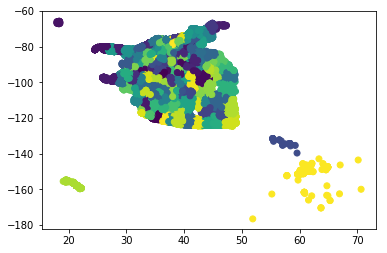

In [8]:
for i in range(len(clusters)):
    df1_us.at[i, 'cluster'] = clusters[i]
plt.scatter(df1_us['latitude'], df1_us['longitude '], c=df1_us['cluster']);
plt.show()

In [9]:
df1_us.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,sight_year,report_year,cluster
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111,1949,2004,55.0
1,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833,1956,2004,55.0
2,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611,1960,2004,130.0
3,10/10/1961 19:00,bristol,tn,us,sphere,300,5 minutes,My father is now 89 my brother 52 the girl wit...,4/27/2007,36.595000,-82.188889,1961,2007,95.0
4,10/10/1965 23:45,norwalk,ct,us,disk,1200,20 minutes,A bright orange color changing to reddish colo...,10/2/1999,41.117500,-73.408333,1965,1999,82.0


In [10]:
df1_us_sorted = df1_us.sort_values(['cluster', 'datetime'], ascending=[True, True])
df1_us_sorted.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,sight_year,report_year,cluster
9109,1/1/1989 23:59,wagoner,ok,us,light,120,1-2 mins,My friend and I who were both 16 at the time w...,3/7/1998,35.959444,-95.369167,1989,1998,0.0
9167,1/1/2001 22:00,kellyville,ok,us,changing,2700,45 min,object that changed from cylinder to triangle&...,2/24/2001,35.943611,-96.213333,2001,2001,0.0
6256,1/10/2000 19:15,mannford,ok,us,oval,8,6 to 8 seconds,Two bright objects perpendicular to one anothe...,1/22/2000,36.133333,-96.354167,2000,2000,0.0
6281,1/10/2003 20:00,huntsville,ar,us,oval,5,5 seconds,It was an overcast night but the stars were ju...,1/17/2004,36.086111,-93.741111,2003,2004,0.0
12111,1/14/2010 19:30,holiday island,ar,us,triangle,600,10 minutes,Triangular patterned lights over Holiday Islan...,2/14/2010,36.485278,-93.731944,2010,2010,0.0
12581,1/15/2012 21:00,garfield,ar,us,changing,4,4 seconds,Bright green fiery object with bent tail of fi...,1/24/2012,36.448333,-93.973889,2012,2012,0.0
12783,1/16/2008 05:07,owasso,ok,us,triangle,240,4 min,Huge triangle shape steady red and white light...,6/12/2008,36.269444,-95.854444,2008,2008,0.0
12920,1/16/2014 19:00,glenpool,ok,us,rectangle,120,1-2 minutes,Several different colored lights in the sky.,1/24/2014,35.955278,-96.008611,2014,2014,0.0
13226,1/17/2014 13:00,glenpool,ok,us,unknown,300,5:00,Two streams flying into each other.,1/24/2014,35.955278,-96.008611,2014,2014,0.0
13243,1/18/1996 06:30,fayetteville,ar,us,unknown,300,5 min.,Woman &amp; husband witness double&#44 paralle...,11/2/1999,36.062500,-94.157222,1996,1999,0.0


In [11]:
def getTokens(cluster_group):
    """ Get the doc as nlp tokens """
    tokens= nlp(cluster_group)
    return tokens

def getTags(tokens):
    
    adjectives=set(["JJ", "JJR", "JJS"])
    nouns=set(["NN", "NNS", "NNP", "NNPS"])

    taglist=[]
    for x in tokens:
        if x.tag_ in adjectives:
            taglist.append("ADJ")
        elif x.tag_ in nouns:
            taglist.append("NOUN")
        elif x.tag == "IN":
            taglist.append("PREP")
        else:
            taglist.append("O")

    tags=' '.join(taglist)  
    
    return tags

In [12]:
def getChar2TokenMap(tags):
    
    """  We'll search over the postag sequence, so we need to get the token ID for any
    character to be able to match the word token. """
    
    ws=re.compile(" ")
    char2token={}

    lastStart=0
    for idx, m in enumerate(ws.finditer(tags)):
        char2token[lastStart]=idx
        lastStart=m.start()+1
        
    return char2token

def getToken(tokenId, char2token):
    
    """ Find the token ID for given character in the POS sequence """
    while(tokenId > 0):
        if tokenId in char2token:
            return char2token[tokenId]
        tokenId-=1
    return None

In [13]:
def find_phrases(cluster_group):
    tokens =  getTokens(cluster_group)
    words = [x.text for x in tokens]
    tags = getTags(tokens)
    char2token = getChar2TokenMap(tags)
    p = re.compile("(((ADJ|NOUN) )+|((ADJ|NOUN) )*(NOUN PREP )((ADJ|NOUN) )*)NOUN")
    mwe_list = ""
    for m in p.finditer(tags):
        startToken = getToken(m.start(),char2token)
        endToken=getToken(m.end(),char2token)
        if endToken is not None and startToken is not None:
            mwe_list += ' '.join(words[startToken:endToken+1]) + " "
    return mwe_list

In [14]:
def load_embeddings(filename, max_vocab_size):
    """
    Load embeddings from file
    Returns
    - embeddings: a list of embedding vectors
    - vocab: a dictionary of {word: idx} pairs where idx points to the index of the 'word' embedding in the embeddings list
    """
    
    vocab={}
    embeddings=[]
    with open(filename) as file:
        
        cols=file.readline().split(" ")
        num_words=int(cols[0])
        size=int(cols[1])
        embeddings.append(np.zeros(size))  # 0 = padding
        embeddings.append(np.zeros(size))  # 1 = UNK,
        vocab["_0_"]=0
        vocab["_UNK_"]=1
        
        for idx,line in enumerate(file):

            if idx+2 >= max_vocab_size:
                break

            cols=line.rstrip().split(" ")
            val=np.array(cols[1:])
            word=cols[0]
            
            embeddings.append(val)
            vocab[word]=idx+2

    return np.array(embeddings), vocab

embeddings, vocab=load_embeddings("glove.42B.300d.50K.w2v.txt", 50000)

In [15]:
"""
Run after downloading glove.42B.300d.50K.txt  for the first time
Only run this cell if you got a 'file not found' error above
"""
from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# First we have to convert the Glove format into w2v format; this creates a new file
glove_file="glove.42B.300d.50K.txt"
glove_in_w2v_format="glove.42B.300d.50K.w2v.txt"
_ = glove2word2vec(glove_file, glove_in_w2v_format)

# now load the embeddings
embeddings, vocab=load_embeddings("glove.42B.300d.50K.w2v.txt", 50000)

In [16]:
def get_doc_representation(doc, vocab, embeddings):
    """
    Return one vector that represents the entire array of input tokens.
    Output shape should == embeddings.shape[1]

    Input: 
        - doc: a scpaCy document instance
        - vocab: a dictionary of (word, index) pairs. 
        'index' denotes the location of each word in the 'embeddings' list
        - embeddings: a list of word embeddings
    """
    
    # (implementation. Taking average of all words in doc:)
    words = []
    for token in doc:
        if token.lower() in vocab:
            words.append(embeddings[vocab[token.lower()]].astype(np.float))
            
    return np.mean(words, axis=0)

In [17]:
def cos_similarity(epicenter, current_sighting):
    """ Returns cosine similarity between two vectors """
    phrase_list_1 = find_phrases(epicenter)
    phrase_list_2 = find_phrases(current_sighting)
    v1 = get_doc_representation(phrase_list_1,  vocab, embeddings)
    v2 = get_doc_representation(phrase_list_2,  vocab, embeddings)
    if np.isnan(v1).all() or np.isnan(v2).all():
        cos = 0
    else:
        cos = np.dot(v1, v2) / (np.sqrt(np.dot(v1,v1)) * np.sqrt(np.dot(v2,v2)))
    return cos

In [18]:
cluster_groups = list(df1_us_sorted.groupby("cluster").groups.keys())

In [20]:
#defining new columns
df1_us_sorted['epicenter'] = 0
df1_us_sorted['similarity_score'] = 0.00

#looping through the all cluster groups
for group in cluster_groups:
    current_group_comments = list(df1_us_sorted[df1_us_sorted["cluster"] == group].sort_values('datetime', ascending=True)["comments"])
    list_of_index = list(df1_us_sorted[df1_us_sorted["cluster"] == group].sort_values('datetime', ascending=True)["comments"].reset_index()["index"])
    
    #defining the epicenter
    epicenter = current_group_comments[0]
    
    #updating table values for epicenter
    df1_us_sorted.loc[list_of_index[0],"epicenter"] = list_of_index[0]
    df1_us_sorted.loc[list_of_index[0],"similarity_score"] = 1
    
    #updating the values for epicenter and similarity for each sighting   
    for i in range(1, len(list_of_index)):
        df1_us_sorted.loc[list_of_index[i],"epicenter"] = list_of_index[0]
        df1_us_sorted.loc[list_of_index[i],"similarity_score"] = cos_similarity(epicenter, current_group_comments[i])
    
    

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [22]:
df1_us_sorted.to_csv("dataset_worked_on.tsv", sep= "\t")

In [23]:
df1_us_sorted.head(20)

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,sight_year,report_year,cluster,epicenter,similarity_score
9109,1/1/1989 23:59,wagoner,ok,us,light,120,1-2 mins,My friend and I who were both 16 at the time w...,3/7/1998,35.959444,-95.369167,1989,1998,0.0,9109,1.000000
9167,1/1/2001 22:00,kellyville,ok,us,changing,2700,45 min,object that changed from cylinder to triangle&...,2/24/2001,35.943611,-96.213333,2001,2001,0.0,9109,0.000000
6256,1/10/2000 19:15,mannford,ok,us,oval,8,6 to 8 seconds,Two bright objects perpendicular to one anothe...,1/22/2000,36.133333,-96.354167,2000,2000,0.0,9109,0.966113
6281,1/10/2003 20:00,huntsville,ar,us,oval,5,5 seconds,It was an overcast night but the stars were ju...,1/17/2004,36.086111,-93.741111,2003,2004,0.0,9109,0.977056
12111,1/14/2010 19:30,holiday island,ar,us,triangle,600,10 minutes,Triangular patterned lights over Holiday Islan...,2/14/2010,36.485278,-93.731944,2010,2010,0.0,9109,0.961707
12581,1/15/2012 21:00,garfield,ar,us,changing,4,4 seconds,Bright green fiery object with bent tail of fi...,1/24/2012,36.448333,-93.973889,2012,2012,0.0,9109,0.971833
12783,1/16/2008 05:07,owasso,ok,us,triangle,240,4 min,Huge triangle shape steady red and white light...,6/12/2008,36.269444,-95.854444,2008,2008,0.0,9109,0.983518
12920,1/16/2014 19:00,glenpool,ok,us,rectangle,120,1-2 minutes,Several different colored lights in the sky.,1/24/2014,35.955278,-96.008611,2014,2014,0.0,9109,0.000000
13226,1/17/2014 13:00,glenpool,ok,us,unknown,300,5:00,Two streams flying into each other.,1/24/2014,35.955278,-96.008611,2014,2014,0.0,9109,0.000000
13243,1/18/1996 06:30,fayetteville,ar,us,unknown,300,5 min.,Woman &amp; husband witness double&#44 paralle...,11/2/1999,36.062500,-94.157222,1996,1999,0.0,9109,0.967357


In [25]:
#to see range
list_of_min_similarity_scores = list(df1_us_sorted[df1_us_sorted["similarity_score"]!=0].groupby("cluster").min()["similarity_score"])

In [26]:
sorted(list_of_min_similarity_scores)

[0.5581040344940199,
 0.6029718666873213,
 0.6846725848341524,
 0.7109454596481783,
 0.7130995086601076,
 0.7190260616751202,
 0.7761218919648603,
 0.776149507184305,
 0.7767854805110055,
 0.7804551528886454,
 0.786535852460223,
 0.791555790511141,
 0.7916972124656628,
 0.7923957554704171,
 0.7967751532620606,
 0.8008154997361852,
 0.8011219199901247,
 0.8043137446702777,
 0.807807865136371,
 0.8121787040737607,
 0.8128232198475417,
 0.8130676801128598,
 0.8132986867532127,
 0.8135725747213762,
 0.8137750247107917,
 0.8154574641312201,
 0.8177418274001081,
 0.8187322861965127,
 0.8199365913592674,
 0.8203425502032425,
 0.821073399072328,
 0.821747965863286,
 0.822388603049525,
 0.8238022769779866,
 0.8245147563735588,
 0.8294532630299787,
 0.829723673557641,
 0.8309903724645865,
 0.8315656751619462,
 0.8338043900858648,
 0.8345482228955078,
 0.8346004282844537,
 0.8363324376440973,
 0.8371210724133398,
 0.8375732325063022,
 0.8407429620864357,
 0.8430247697981097,
 0.8442448933796971,


In [24]:
df1_us_sorted.loc[9167, "comments"]

'object that changed from cylinder to triangle&#44no sound.'